In [287]:
# Standard library
import os
import pickle
import time
import warnings

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Parallel processing
from joblib import Parallel, delayed

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

# torchvision
import torchvision.transforms as transforms
from torchvision.io import ImageReadMode, read_image
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# timm (PyTorch image models)
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

# Scikit-learn
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.feature_selection import RFE, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

# XGBoost & LightGBM
import lightgbm as lgb
import xgboost as xgb

# OpenCV & image processing
import cv2
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.filters import gabor, sobel
from skimage.measure import label, regionprops

# Signal processing
from scipy.fftpack import dct

# Suppress warnings
warnings.filterwarnings('ignore')
import torchvision.models as models

# Importações para paralelização e processamento
from joblib import Parallel, delayed
from tqdm import tqdm

# Importações scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, 
    confusion_matrix, classification_report, roc_auc_score
)


In [288]:
# Configurações globais
SEED = 42
IMAGE_SIZE = 224  # Aumentei o tamanho da imagem para capturar mais detalhes
BATCH_SIZE = 16
EPOCHS = 50
num_epochs = EPOCHS
LEARNING_RATE = 3e-5  # Reduzido para treinamento mais estável
PATIENCE = 10  # Early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4
MODEL_NAME = "tf_efficientnetv2_b3"  # EfficientNetV2-B3 do timm
ALPHA_INTEGRATION = 0.3

# Fixar seeds para reprodutibilidade
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Diretórios
train_dir = 'dataset/processado/train/'
val_dir = 'dataset/processado/validation/'
test_dir = 'dataset/processado/test/'
save_dir = 'models/efficientnetv2'
os.makedirs(save_dir, exist_ok=True)

In [289]:
print(f"Diretório de treino: {train_dir}")
print(f"Diretório de validação: {val_dir}")
print(f"Diretório de teste: {test_dir}")

Diretório de treino: dataset/processado/train/
Diretório de validação: dataset/processado/validation/
Diretório de teste: dataset/processado/test/


In [290]:
# Verificar número de imagens em cada diretório
for name, directory in [("Treino ALL", os.path.join(train_dir, "all")), 
                        ("Treino HEM", os.path.join(train_dir, "hem")),
                        ("Validação ALL", os.path.join(val_dir, "all")),
                        ("Validação HEM", os.path.join(val_dir, "hem")),
                        ("Teste ALL", os.path.join(test_dir, "all")),
                        ("Teste HEM", os.path.join(test_dir, "hem"))]:
    if os.path.exists(directory):
        num_images = len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.bmp'))])
        print(f"{name}: {num_images} imagens")
    else:
        print(f"{name}: diretório não existe")

Treino ALL: 8292 imagens
Treino HEM: 8092 imagens
Validação ALL: 1744 imagens
Validação HEM: 582 imagens
Teste ALL: 749 imagens
Teste HEM: 227 imagens


In [291]:
def create_ensemble_predictions(models_list, dataloaders_list, device):
    """
    Cria previsões de ensemble a partir de vários modelos
    """
    all_probs = []
    
    # Para cada modelo e seu respectivo dataloader
    for model, dataloader in zip(models_list, dataloaders_list):
        model.eval()
        probs = []
        
        with torch.no_grad():
            for inputs, *_ in dataloader:  # *_ para lidar com diferentes tipos de dataloaders
                inputs = inputs.to(device)
                outputs = model(inputs)
                batch_probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                probs.extend(batch_probs)
        
        all_probs.append(probs)
    
    # Calcular média das probabilidades
    ensemble_probs = np.mean(all_probs, axis=0)
    
    return ensemble_probs

In [292]:
# 1. DATASET E CARREGAMENTO DE DADOS                   #
#------------------------------------------------------#

class LeukemiaDataset(Dataset):
    """Dataset personalizado para imagens de células leucêmicas com suporte a extração de características"""
    def __init__(self, data_dir, transform=None, return_features=False, feature_extractor=None):
        self.data_dir = data_dir
        self.transform = transform
        self.return_features = return_features
        self.feature_extractor = feature_extractor
        
        self.images = []
        self.labels = []
        
        # Carregar imagens ALL (classe 1)
        all_dir = os.path.join(data_dir, 'all')
        if os.path.exists(all_dir):
            for img_name in os.listdir(all_dir):
                if img_name.endswith(('.jpg', '.png', '.bmp')):
                    self.images.append(os.path.join(all_dir, img_name))
                    self.labels.append(1)
        
        # Carregar imagens HEM (classe 0)
        hem_dir = os.path.join(data_dir, 'hem')
        if os.path.exists(hem_dir):
            for img_name in os.listdir(hem_dir):
                if img_name.endswith(('.jpg', '.png', '.bmp')):
                    self.images.append(os.path.join(hem_dir, img_name))
                    self.labels.append(0)
        
        print(f"Carregado dataset com {len(self.images)} imagens - ALL: {self.labels.count(1)}, HEM: {self.labels.count(0)}")
        
        # Cache para features extraídas
        self.feature_cache = {}
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Leitura da imagem com OpenCV (BGR)
        image = cv2.imread(img_path)
        
        # Conversão para RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Aplicar transformações
        if self.transform:
            image = self.transform(image)
        
        # Se não estiver retornando features, apenas retornar imagem e label
        if not self.return_features:
            return image, label
        
        # Verificar se as features estão em cache
        if img_path in self.feature_cache:
            features = self.feature_cache[img_path]
        else:
            # Extrair features se tiver um extrator
            if self.feature_extractor:
                features = self.feature_extractor.extract_features(img_path)
                self.feature_cache[img_path] = features
            else:
                # Se não tiver extrator, usar array vazio ou dummy
                features = np.zeros(1387)  # Ajuste este número para a dimensionalidade das suas features
        
        return image, features, label


# Transformações de dados com aumento avançado inspirado no artigo
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.7),  # Aumento de probabilidade
    transforms.RandomVerticalFlip(p=0.7),    # Aumento de probabilidade
    transforms.RandomRotation(45),           # Mais rotação
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # Adicionar transformações para aumentar robustez
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregar datasets
train_dataset = LeukemiaDataset(train_dir, transform=train_transform)
val_dataset = LeukemiaDataset(val_dir, transform=val_transform)
test_dataset = LeukemiaDataset(test_dir, transform=val_transform)

# Calcular pesos de classes para lidar com desbalanceamento
class_counts = [train_dataset.labels.count(0), train_dataset.labels.count(1)]
class_weights = torch.FloatTensor([len(train_dataset)/class_counts[0], len(train_dataset)/class_counts[1]])
class_weights = class_weights / class_weights.sum()
print(f"Pesos das classes: {class_weights}")

# Criar DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Carregado dataset com 16384 imagens - ALL: 8292, HEM: 8092
Carregado dataset com 2326 imagens - ALL: 1744, HEM: 582
Carregado dataset com 976 imagens - ALL: 749, HEM: 227
Pesos das classes: tensor([0.5061, 0.4939])


In [293]:
# 2. EXTRAÇÃO DE CARACTERÍSTICAS                       #
#------------------------------------------------------#

class FeatureExtractor:
    """Extrator de características baseado nos trabalhos de Sant'Anna et al."""
    def __init__(self, cache_dir=None):
        self.cache_dir = cache_dir
        if cache_dir:
            os.makedirs(cache_dir, exist_ok=True)
        self.feature_cache = {}  # Cache em memória
    
    def extract_features(self, img_path):
        """Extrai todas as características descritas nos artigos"""
        # Verificar cache
        if img_path in self.feature_cache:
            return self.feature_cache[img_path]
        
        # Verificar cache em disco
        if self.cache_dir:
            cache_file = os.path.join(self.cache_dir, os.path.basename(img_path) + '.pkl')
            if os.path.exists(cache_file):
                with open(cache_file, 'rb') as f:
                    features = pickle.load(f)
                self.feature_cache[img_path] = features
                return features
        
        # Ler imagem
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Não foi possível ler a imagem: {img_path}")
        
        # Converter para RGB e grayscale
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Converter para HSV
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        # 1. Características estatísticas de primeira ordem
        statistical_features = self._extract_statistical_features(img_rgb, img_hsv)
        
        # 2. Características de textura
        texture_features = self._extract_texture_features(img_gray)
        
        # 3. Características morfológicas
        morphological_features = self._extract_morphological_features(img_gray, img_rgb, img_hsv)
        
        # 4. Características de contorno
        contour_features = self._extract_contour_features(img_gray)
        
        # 5. Características DCT (Discrete Cosine Transform)
        dct_features = self._extract_dct_features(img_gray)
        
        # 6. Características adicionais - Gabor e LBP (não discutidas no artigo original)
        gabor_features = self._extract_gabor_features(img_gray)
        lbp_features = self._extract_lbp_features(img_gray)
        
        # Combinar todas as características em um único vetor
        all_features = np.concatenate([
            statistical_features,
            texture_features,
            morphological_features,
            contour_features,
            dct_features,
            gabor_features,
            lbp_features
        ])
        
        # Armazenar em cache
        self.feature_cache[img_path] = all_features
        
        # Salvar em disco se necessário
        if self.cache_dir:
            with open(cache_file, 'wb') as f:
                pickle.dump(all_features, f)
        
        return all_features
    
    def _extract_statistical_features(self, img_rgb, img_hsv):
        """Extrai características estatísticas de primeira ordem dos canais RGB e HSV"""
        features = []
        
        # Processar cada canal do RGB
        for i, channel_name in enumerate(['R', 'G', 'B']):
            channel = img_rgb[:, :, i].flatten()
            
            # Estatísticas básicas
            mean = np.mean(channel)
            std = np.std(channel)
            skewness = np.mean(((channel - mean) / (std + 1e-10)) ** 3) if std > 0 else 0
            kurtosis = np.mean(((channel - mean) / (std + 1e-10)) ** 4) - 3 if std > 0 else 0
            
            # Estatísticas de ordem
            min_val = np.min(channel)
            max_val = np.max(channel)
            median = np.median(channel)
            q1 = np.percentile(channel, 25)
            q3 = np.percentile(channel, 75)
            
            # Métricas de energia e entropia
            hist, _ = np.histogram(channel, bins=256, range=(0, 256), density=True)
            energy = np.sum(hist ** 2)
            entropy = -np.sum(hist * np.log2(hist + 1e-10))
            
            # Adicionar todas as estatísticas ao vetor de características
            features.extend([mean, std, skewness, kurtosis, min_val, max_val, median, q1, q3, energy, entropy])
        
        # Processar cada canal do HSV
        for i, channel_name in enumerate(['H', 'S', 'V']):
            channel = img_hsv[:, :, i].flatten()
            
            # Mesmas estatísticas para HSV
            mean = np.mean(channel)
            std = np.std(channel)
            skewness = np.mean(((channel - mean) / (std + 1e-10)) ** 3) if std > 0 else 0
            kurtosis = np.mean(((channel - mean) / (std + 1e-10)) ** 4) - 3 if std > 0 else 0
            
            min_val = np.min(channel)
            max_val = np.max(channel)
            median = np.median(channel)
            q1 = np.percentile(channel, 25)
            q3 = np.percentile(channel, 75)
            
            hist, _ = np.histogram(channel, bins=256, range=(0, 256), density=True)
            energy = np.sum(hist ** 2)
            entropy = -np.sum(hist * np.log2(hist + 1e-10))
            
            features.extend([mean, std, skewness, kurtosis, min_val, max_val, median, q1, q3, energy, entropy])
        
        # Total: (11 estatísticas * 3 canais RGB) + (11 estatísticas * 3 canais HSV) = 66 características
        return np.array(features)
    
    def _extract_texture_features(self, img_gray):
        """Extrai características de textura usando GLCM"""
        # Normalizar imagem
        img_gray_norm = img_gray.astype(np.uint8)
        
        # Calcular GLCM para diferentes ângulos e distâncias
        distances = [1, 3, 5]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        
        features = []
        
        for d in distances:
            glcm = graycomatrix(img_gray_norm, [d], angles, 256, symmetric=True, normed=True)
            
            for prop in properties:
                feature = graycoprops(glcm, prop).flatten()
                features.extend(feature)
        
        # 6 propriedades * 4 ângulos * 3 distâncias = 72 características
        
        # Adicionar algumas medidas de textura adicionais (não discutidas no artigo original)
        sobel_img = sobel(img_gray_norm)
        sobel_energy = np.mean(sobel_img ** 2)
        features.append(sobel_energy)
        
        # Variação local
        local_var = np.var(img_gray_norm)
        features.append(local_var)
        
        # Energia total
        total_energy = np.sum(img_gray_norm ** 2)
        features.append(total_energy)
        
        return np.array(features)
    
    def _extract_morphological_features(self, img_gray, img_rgb, img_hsv):
        """Extrai características morfológicas da célula"""
        # Binarizar imagem para segmentar a célula do fundo
        _, binary = cv2.threshold(img_gray, 30, 255, cv2.THRESH_BINARY)
        
        # Encontrar contornos
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Se não encontrar contornos, retornar zeros
        if not contours:
            return np.zeros(20)
        
        # Pegar o maior contorno (assumindo que é a célula)
        contour = max(contours, key=cv2.contourArea)
        
        # Calcular características baseadas no contorno
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h > 0 else 0
        rect_area = w * h
        extent = area / rect_area if rect_area > 0 else 0
        
        # Calcular convex hull
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0
        
        # Calcular elipse
        (x_e, y_e), (MA, ma), angle = cv2.fitEllipse(contour) if len(contour) >= 5 else ((0, 0), (0, 0), 0)
        eccentricity = np.sqrt(1 - (ma / MA)**2) if MA > 0 else 0
        
        # Calcular momento
        M = cv2.moments(contour)
        hu_moments = cv2.HuMoments(M).flatten() if M["m00"] != 0 else np.zeros(7)
        
        # Calcular cores médias
        mask = np.zeros(img_gray.shape, dtype=np.uint8)
        cv2.drawContours(mask, [contour], 0, 255, -1)
        
        mean_rgb = [np.mean(img_rgb[:, :, i][mask == 255]) if np.sum(mask) > 0 else 0 for i in range(3)]
        mean_hsv = [np.mean(img_hsv[:, :, i][mask == 255]) if np.sum(mask) > 0 else 0 for i in range(3)]
        
        # Combinar todas as características
        features = [
            area, perimeter, aspect_ratio, extent, solidity, eccentricity,
            *hu_moments,
            *mean_rgb,
            *mean_hsv
        ]
        
        return np.array(features)
    
    def _extract_contour_features(self, img_gray):
        """Extrai características do contorno usando o método CDF (Centroid Distance Function)"""
        # Binarizar imagem
        _, binary = cv2.threshold(img_gray, 30, 255, cv2.THRESH_BINARY)
        
        # Encontrar contornos
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Se não encontrar contornos, retornar zeros
        if not contours:
            return np.zeros(160)
        
        # Pegar o maior contorno
        contour = max(contours, key=cv2.contourArea)
        
        # Calcular o centroide
        M = cv2.moments(contour)
        if M["m00"] == 0:
            return np.zeros(160)
        
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        
        # Calcular a distância de cada ponto do contorno ao centroide (CDF)
        # Reamostrar para 320 pontos conforme o artigo
        contour_resample = []
        step = len(contour) / 320
        
        for i in range(320):
            idx = min(int(i * step), len(contour) - 1)
            contour_resample.append(contour[idx][0])
        
        # Calcular CDF
        cdf = []
        for point in contour_resample:
            distance = np.sqrt((point[0] - cx)**2 + (point[1] - cy)**2)
            cdf.append(distance)
        
        # Normalizar CDF
        cdf = np.array(cdf)
        if np.max(cdf) > 0:
            cdf = cdf / np.max(cdf)
        
        # Calcular descritores de Fourier
        fourier_desc = np.abs(np.fft.fft(cdf))
        
        # Usar apenas os primeiros 160 coeficientes (como no artigo)
        fourier_desc = fourier_desc[:160]
        
        # Normalizar e aplicar log
        if np.max(fourier_desc) > 0:
            fourier_desc = np.log10(1 + fourier_desc / np.max(fourier_desc))
        
        return fourier_desc
    
    def _extract_dct_features(self, img_gray):
        """Extrai características baseadas na DCT (Discrete Cosine Transform)"""
        # Calcular DCT
        dct_coeff = dct(dct(img_gray.T, norm='ortho').T, norm='ortho')
        
        # Zigzag scan para ordenar coeficientes por frequência
        h, w = dct_coeff.shape
        zigzag_indices = []
        
        for sum_idx in range(h + w - 1):
            if sum_idx % 2 == 0:  # Diagonal para baixo
                start_idx = min(sum_idx, h - 1)
                end_idx = max(0, sum_idx - (w - 1))
                for i in range(start_idx, end_idx - 1, -1):
                    j = sum_idx - i
                    if j < w:
                        zigzag_indices.append((i, j))
            else:  # Diagonal para cima
                start_idx = min(sum_idx, w - 1)
                end_idx = max(0, sum_idx - (h - 1))
                for j in range(start_idx, end_idx - 1, -1):
                    i = sum_idx - j
                    if i < h:
                        zigzag_indices.append((i, j))
        
        # Obter coeficientes em ordem zigzag
        zigzag_coeff = [dct_coeff[i, j] for i, j in zigzag_indices[:1024]]
        
        # Se não tiver 1024 coeficientes, preencher com zeros
        zigzag_coeff = np.array(zigzag_coeff + [0] * (1024 - len(zigzag_coeff)))
        
        # Normalizar e aplicar log
        zigzag_coeff = np.abs(zigzag_coeff)
        if np.max(zigzag_coeff) > 0:
            zigzag_coeff = np.log10(1 + zigzag_coeff / np.max(zigzag_coeff))
        
        return zigzag_coeff
    
    def _extract_gabor_features(self, img_gray):
        """Extrai características usando filtros de Gabor (não discutido no artigo original)"""
        # Definir parâmetros do filtro Gabor
        thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        frequencies = [0.1, 0.25, 0.4]
        
        features = []
        
        for theta in thetas:
            for frequency in frequencies:
                # Aplicar filtro de Gabor
                real, imag = gabor(img_gray, frequency=frequency, theta=theta, 
                                   sigma_x=4, sigma_y=4, n_stds=3)
                
                # Calcular estatísticas da resposta do filtro
                mean = np.mean(np.abs(real) + np.abs(imag))
                std = np.std(np.abs(real) + np.abs(imag))
                energy = np.sum((np.abs(real) + np.abs(imag)) ** 2)
                
                features.extend([mean, std, energy])
        
        # 3 estatísticas * 4 direções * 3 frequências = 36 características
        return np.array(features)
    
    def _extract_lbp_features(self, img_gray):
        """Extrai características usando Local Binary Patterns (não discutido no artigo original)"""
        # Calcular LBP com diferentes raios e pontos
        radii = [1, 2, 3]
        n_points = [8, 16, 24]
        
        features = []
        
        for radius, points in zip(radii, n_points):
            lbp = local_binary_pattern(img_gray, points, radius, method='uniform')
            
            # Calcular histograma e normalizar
            hist, _ = np.histogram(lbp.ravel(), bins=points + 2, range=(0, points + 2), density=True)
            
            features.extend(hist)
        
        # 10 bins * 3 combinações = 30 características
        return np.array(features)

In [294]:
#------------------------------------------------------#
# 3. MODELOS DE DEEP LEARNING                          #
#------------------------------------------------------#

# Modelo com Attention e Squeeze-Excitation aprimorado
class AttentionModel(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_classes=2, pretrained=True):
        super(AttentionModel, self).__init__()
        
        # Carregar modelo pré-treinado do timm
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        
        # Obter número de features da última camada
        if hasattr(self.backbone, 'global_pool') and hasattr(self.backbone, 'classifier'):
            backbone_out = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        else:
            # Fallback para outros modelos
            backbone_out = self.backbone.num_features
            if hasattr(self.backbone, 'head'):
                self.backbone.head = nn.Identity()
            else:
                self.backbone.fc = nn.Identity()
        
        # Camada de atenção inspiradas em Squeeze-and-Excitation
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(backbone_out, backbone_out // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(backbone_out // 16, backbone_out, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Head de classificação com dropout para regularização
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(backbone_out, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Extrair features do backbone
        features = self.backbone(x)
        
        # Aplicar atenção (quando as features ainda são mapas)
        if len(features.shape) == 4:  # Se for um tensor 4D (batch, channels, height, width)
            att = self.attention(features)
            features = features * att
            features = torch.flatten(features, 1)
        
        # Classificação
        x = self.classifier(features)
        return x

In [295]:
class HybridModel(nn.Module):
    """Modelo híbrido que combina CNN com características handcrafted"""
    def __init__(self, num_classes=2, feature_size=1387, pretrained=True):
        super(HybridModel, self).__init__()
        
        # Carregar CNN
        self.cnn = AttentionModel(num_classes=num_classes, pretrained=pretrained)
        
        # Extrair o número de features do CNN
        cnn_features = 512  # Definido no classifier do AttentionModel
        
        # Rede para processar características handcrafted
        self.feature_network = nn.Sequential(
            nn.Linear(feature_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        # Mecanismo de fusão
        self.fusion = nn.Sequential(
            nn.Linear(cnn_features + 256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x_img, x_features):
        # Processar a imagem com CNN (exceto o classificador final)
        cnn_features = self.cnn.backbone.features(x_img)
        cnn_features = self.cnn.attention(cnn_features) * cnn_features
        cnn_features = F.adaptive_avg_pool2d(cnn_features, 1)
        cnn_features = torch.flatten(cnn_features, 1)
        cnn_features = self.cnn.classifier[:-1](cnn_features)  # Pegar features antes do último classificador
        
        # Processar características handcrafted
        handcrafted_features = self.feature_network(x_features)
        
        # Combinar características
        combined_features = torch.cat([cnn_features, handcrafted_features], dim=1)
        
        # Fusão e classificação final
        output = self.fusion(combined_features)
        
        return output

    def get_cnn_features(self, x_img):
        # Método para obter apenas as features da CNN
        cnn_features = self.cnn.backbone.features(x_img)
        cnn_features = self.cnn.attention(cnn_features) * cnn_features
        cnn_features = F.adaptive_avg_pool2d(cnn_features, 1)
        cnn_features = torch.flatten(cnn_features, 1)
        cnn_features = self.cnn.classifier[:-1](cnn_features)
        return cnn_features
    
    def get_handcrafted_features(self, x_features):
        # Método para obter apenas as features handcrafted processadas
        handcrafted_features = self.feature_network(x_features)
        return handcrafted_features

In [296]:
#------------------------------------------------------#
# 4. TREINAMENTO E VALIDAÇÃO                           #
#------------------------------------------------------#

class EarlyStopping:
    """Implementação de Early Stopping para interromper o treinamento"""
    def __init__(self, patience=7, min_delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        """Salva o modelo quando há melhora na performance de validação"""
        torch.save(model.state_dict(), self.path)

In [297]:
def train_cnn_model(model, train_loader, val_loader, criterion, optimizer, 
                   scheduler, num_epochs, device, save_path):
    """Treina o modelo CNN"""
    # Inicialização do early stopping
    early_stopping = EarlyStopping(patience=PATIENCE, path=save_path)
    
    # Registrar métricas
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': []
    }
    
    best_val_f1 = 0.0
    
    # Loop de épocas
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Treinar
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []
        
        for inputs, targets in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            
            # Armazenar predições e alvos para calcular métricas
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())
        
        # Calcular métricas de treino
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        
        # Avaliar
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc='Validation'):
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # Forward
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
                
                # Armazenar predições e alvos
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())
        
        # Calcular métricas de validação
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds, average='weighted')
        
        # Atualizar scheduler
        if scheduler:
            scheduler.step(val_loss)
        
        # Registrar métricas
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        
        # Imprimir progresso
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}')
        
        # Verificar se é o melhor modelo
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), save_path.replace('.pt', '_best.pt'))
            print(f'Novo melhor modelo salvo com F1-score: {val_f1:.4f}')
        
        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping ativado na época {epoch+1}')
            break
    
    # Carregar o melhor modelo
    model.load_state_dict(torch.load(save_path.replace('.pt', '_best.pt')))
    
    return model, history

In [298]:
def train_hybrid_model(model, train_loader, val_loader, criterion, optimizer,
                     scheduler, num_epochs, device, save_path):
    """Treina o modelo híbrido que combina CNN com características handcrafted"""
    # Inicialização do early stopping
    early_stopping = EarlyStopping(patience=PATIENCE, path=save_path)
    
    # Registrar métricas
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': []
    }
    
    best_val_f1 = 0.0
    
    # Loop de épocas
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Treinar
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []
        
        for inputs, features, targets in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            features = features.to(device)
            targets = targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = model(inputs, features)
            loss = criterion(outputs, targets)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            
            # Armazenar predições e alvos para calcular métricas
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())
        
        # Calcular métricas de treino
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        
        # Avaliar
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for inputs, features, targets in tqdm(val_loader, desc='Validation'):
                inputs = inputs.to(device)
                features = features.to(device)
                targets = targets.to(device)
                
                # Forward
                outputs = model(inputs, features)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
                
                # Armazenar predições e alvos
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())
        
        # Calcular métricas de validação
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds, average='weighted')
        
        # Atualizar scheduler
        if scheduler:
            scheduler.step(val_loss)
        
        # Registrar métricas
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        
        # Imprimir progresso
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}')
        
        # Verificar se é o melhor modelo
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), save_path.replace('.pt', '_best.pt'))
            print(f'Novo melhor modelo salvo com F1-score: {val_f1:.4f}')
        
        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping ativado na época {epoch+1}')
            break
    
    # Carregar o melhor modelo
    model.load_state_dict(torch.load(save_path.replace('.pt', '_best.pt')))
    
    return model, history

In [299]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc='Evaluating'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Acumular estatísticas
            total_loss += loss.item() * inputs.size(0)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    # Cálculo de métricas mais abrangentes
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    precision = precision_score(all_targets, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_probs)
    
    results = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'auc': auc,
        'confusion_matrix': conf_matrix,
        'predictions': all_preds,
        'targets': all_targets,
        'probabilities': all_probs
    }
    
    return results

In [300]:
#------------------------------------------------------#
# 5. ENSEMBLE LEARNING                                 #
#------------------------------------------------------#

def train_traditional_models(X_train, y_train, feature_selector=None):
    """Treina modelos tradicionais (SVM, NB, KNN, etc.) com as características extraídas"""
    # Aplicar seleção de características se especificado
    if feature_selector:
        X_train = feature_selector.transform(X_train)
    
    # Inicializar modelos
    models = {
        'svm': SVC(probability=True, kernel='rbf', C=10.0, gamma='scale', random_state=SEED),
        'naive_bayes': GaussianNB(),
        'knn': KNeighborsClassifier(n_neighbors=5, weights='distance'),
        'xgboost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=SEED),
        'lightgbm': lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=SEED)
    }
    
    # Treinar cada modelo
    trained_models = {}
    
    for name, model in models.items():
        print(f"Treinando modelo {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
        
    return trained_models

In [301]:
def create_ensemble_model(trained_models, voting='soft'):
    """Cria um modelo ensemble usando os modelos treinados"""
    # Criar lista de estimadores para o VotingClassifier
    estimators = [(name, model) for name, model in trained_models.items()]
    
    # Criar ensemble com votação
    ensemble = VotingClassifier(estimators=estimators, voting=voting)
    
    return ensemble

def create_stacking_model(trained_models, X_train, y_train, meta_learner=None):
    """Cria um modelo stacking usando os modelos treinados"""
    # Criar lista de estimadores para o StackingClassifier
    estimators = [(name, model) for name, model in trained_models.items()]
    
    # Meta-learner padrão se não for especificado
    if meta_learner is None:
        meta_learner = LogisticRegression(random_state=SEED)
    
    # Criar stacking
    stacking = StackingClassifier(estimators=estimators, final_estimator=meta_learner, cv=5)
    
    # Treinar stacking
    stacking.fit(X_train, y_train)
    
    return stacking

In [302]:
def alpha_integration(predictions, alpha=ALPHA_INTEGRATION):
    """Implementa a integração alpha para combinar previsões de diferentes modelos"""
    # Validar input
    if not predictions:
        raise ValueError("Não há previsões para integrar")
    
    num_models = len(predictions)
    num_samples = len(predictions[0])
    num_classes = 2  # binário
    
    # Inicializar matriz de integração
    integrated = np.zeros((num_samples, num_classes))
    
    # Para cada amostra
    for i in range(num_samples):
        # Para cada classe
        for j in range(num_classes):
            # Pegar todas as previsões para esta amostra e classe
            preds = [p[i, j] for p in predictions]
            
            # Aplicar integração alpha
            if alpha == 0:  # caso especial: média geométrica
                integrated[i, j] = np.exp(np.mean(np.log(np.maximum(preds, 1e-10))))
            elif alpha == 1:  # caso especial: média aritmética
                integrated[i, j] = np.mean(preds)
            else:
                # Fórmula geral da integração alpha
                transformed = np.sum([(p ** alpha) for p in preds]) / num_models
                integrated[i, j] = transformed ** (1 / alpha)
    
    # Normalizar para garantir que soma em cada linha é 1
    row_sums = integrated.sum(axis=1, keepdims=True)
    integrated = integrated / row_sums
    
    return integrated

In [303]:
def evaluate_traditional_models(models, X_test, y_test, feature_selector=None):
    """Avalia modelos tradicionais e retorna métricas"""
    results = {}
    predictions = {}
    probabilities = {}
    
    # Aplicar seleção de características se especificado
    if feature_selector:
        X_test = feature_selector.transform(X_test)
    
    # Avaliar cada modelo
    for name, model in models.items():
        # Predições
        y_pred = model.predict(X_test)
        
        # Probabilidades (para modelos que suportam)
        try:
            y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
        except:
            y_prob = np.zeros(len(y_test))
        
        # Métricas
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        
        # Tentar calcular AUC
        try:
            auc = roc_auc_score(y_test, y_prob)
        except:
            auc = 0.5
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Relatório de classificação
        class_report = classification_report(y_test, y_pred, target_names=['hem', 'all'])
        
        # Armazenar resultados
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'recall': recall,
            'precision': precision,
            'auc': auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        predictions[name] = y_pred
        probabilities[name] = y_prob
        
        print(f"\nMétrica do modelo {name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"AUC: {auc:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Classification Report:\n{class_report}")
    
    return results, predictions, probabilities


In [304]:
#------------------------------------------------------#
# 6. FEATURE SELECTION E ANÁLISE                       #
#------------------------------------------------------#

def select_features_with_pca(X, n_components=0.95):
    """Reduz dimensionalidade usando PCA com tratamento para NaN"""
    # Verificar e tratar valores NaN
    if np.isnan(X).any():
        print("ATENÇÃO: Detectados valores NaN nos dados. Substituindo por zeros...")
        X_clean = np.nan_to_num(X, nan=0.0)
    else:
        X_clean = X
    
    # Aplicar normalização antes do PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"Dimensionalidade reduzida de {X_clean.shape[1]} para {X_pca.shape[1]} características")
    print(f"Variância explicada: {np.sum(pca.explained_variance_ratio_):.4f}")
    
    # Retornar também o scaler para aplicar nas features de validação
    return X_pca, pca, scaler

def select_features_with_rfe(X, y, estimator=None, n_features_to_select=268):
    """Seleciona características usando Recursive Feature Elimination com tratamento para NaN"""
    # Verificar e tratar valores NaN
    if np.isnan(X).any():
        print("ATENÇÃO: Detectados valores NaN nos dados. Substituindo por zeros...")
        X_clean = np.nan_to_num(X, nan=0.0)
    else:
        X_clean = X
    
    # Aplicar normalização
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    if estimator is None:
        estimator = LogisticRegression(random_state=SEED, max_iter=1000)
    
    selector = RFE(estimator, n_features_to_select=n_features_to_select, step=10)
    X_selected = selector.fit_transform(X_scaled, y)
    
    print(f"Selecionado {X_selected.shape[1]} características de {X_clean.shape[1]}")
    
    return X_selected, selector, scaler

def select_features_with_importance(X, y, estimator=None, threshold='median'):
    """Seleciona características baseadas em importância com tratamento para NaN"""
    # Verificar e tratar valores NaN
    if np.isnan(X).any():
        print("ATENÇÃO: Detectados valores NaN nos dados. Substituindo por zeros...")
        X_clean = np.nan_to_num(X, nan=0.0)
    else:
        X_clean = X
    
    # Aplicar normalização
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    if estimator is None:
        estimator = xgb.XGBClassifier(
            n_estimators=100, 
            random_state=SEED,
            use_label_encoder=False,
            eval_metric='logloss'  # Evitar warnings
        )
    
    selector = SelectFromModel(estimator, threshold=threshold)
    X_selected = selector.fit_transform(X_scaled, y)
    
    print(f"Selecionado {X_selected.shape[1]} características de {X_clean.shape[1]}")
    
    return X_selected, selector, scaler

def sequential_feature_selection(X, y, estimator=None, n_features_to_select=268, direction='forward'):
    """Seleção sequencial de características com tratamento para NaN"""
    # Verificar e tratar valores NaN
    if np.isnan(X).any():
        print("ATENÇÃO: Detectados valores NaN nos dados. Substituindo por zeros...")
        X_clean = np.nan_to_num(X, nan=0.0)
    else:
        X_clean = X
    
    # Aplicar normalização
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    if estimator is None:
        estimator = LogisticRegression(random_state=SEED, max_iter=1000)
    
    selector = SequentialFeatureSelector(
        estimator, 
        n_features_to_select=n_features_to_select,
        direction=direction,
        scoring='f1',
        cv=5,
        n_jobs=-1  # Usar todos os cores disponíveis
    )
    
    X_selected = selector.fit_transform(X_scaled, y)
    
    print(f"Selecionado {X_selected.shape[1]} características de {X_clean.shape[1]}")
    
    return X_selected, selector, scaler

def analyze_feature_importance(feature_names, model, top_n=20):
    """Analisa e visualiza a importância das características para um modelo"""
    # Verificar se o modelo tem atributo feature_importances_
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        raise ValueError("O modelo não tem atributos de importância de features")
    
    # Verificar e tratar valores NaN em importance
    if np.isnan(importance).any():
        print("ATENÇÃO: Detectados valores NaN nas importâncias. Substituindo por zeros...")
        importance = np.nan_to_num(importance, nan=0.0)
    
    # Garantir que feature_names tem o mesmo tamanho que importance
    if len(feature_names) != len(importance):
        print(f"ATENÇÃO: Incompatibilidade de dimensões entre nomes ({len(feature_names)}) e importâncias ({len(importance)})")
        # Ajustar tamanho se necessário
        if len(feature_names) > len(importance):
            feature_names = feature_names[:len(importance)]
        else:
            importance = importance[:len(feature_names)]
    
    # Criar DataFrame para visualização
    features_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    
    # Ordenar por importância
    features_df = features_df.sort_values('importance', ascending=False)
    
    # Plotar top N características
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=features_df.head(top_n))
    plt.title(f'Top {top_n} características mais importantes')
    plt.tight_layout()
    
    return features_df

In [305]:
#------------------------------------------------------#
# 7. VISUALIZAÇÃO E ANÁLISE DE RESULTADOS              #
#------------------------------------------------------#

def plot_training_history(history):
    """Plota história de treinamento"""
    plt.figure(figsize=(15, 5))
    
    # Plot de loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot de acurácia
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot de F1-score
    plt.subplot(1, 3, 3)
    plt.plot(history['train_f1'], label='Train')
    plt.plot(history['val_f1'], label='Validation')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(conf_matrix, class_names=['hem', 'all']):
    """Plota matriz de confusão"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_probs, model_names=None):
    """Plota curva ROC para um ou mais modelos"""
    plt.figure(figsize=(10, 8))
    
    if isinstance(y_probs, list):
        # Múltiplos modelos
        if model_names is None:
            model_names = [f'Model {i+1}' for i in range(len(y_probs))]
        
        for i, probs in enumerate(y_probs):
            fpr, tpr, _ = roc_curve(y_true, probs)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})')
    else:
        # Um único modelo
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def visualize_model_predictions(model, test_loader, device, num_images=5, is_hybrid=False):
    """Visualiza algumas predições do modelo"""
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for batch in test_loader:
            if is_hybrid:
                inputs, features, labels = batch
                inputs = inputs.to(device)
                features = features.to(device)
                outputs = model(inputs, features)
            else:
                inputs, labels = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2 + 1, 2, images_so_far)
                ax.axis('off')
                
                # Converter tensor para imagem
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                
                # Desnormalizar se necessário
                img = np.clip(img, 0, 1)
                
                # Mostrar imagem
                ax.imshow(img)
                
                # Título: classe prevista (verde se correta, vermelha se errada)
                true_label = labels[j].item()
                predicted_label = preds[j].item()
                
                color = 'green' if predicted_label == true_label else 'red'
                ax.set_title(f'Pred: {predicted_label} (True: {true_label})', color=color)
                
                if images_so_far == num_images:
                    plt.tight_layout()
                    return
        
        plt.tight_layout()

In [306]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.criterion = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, inputs, targets):
        ce_loss = self.criterion(inputs, targets)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return loss.mean()

In [307]:
def display_final_results(history, results, model_name="Modelo"):
    """Exibe um quadro conclusivo com métricas detalhadas após o treinamento"""
    print("\n" + "="*50)
    print(f"RESULTADOS DO TREINAMENTO: {model_name}")
    print("="*50)
    
    if history:
        best_epoch = np.argmax(history['val_f1'])
        print(f"Melhor época: {best_epoch+1}/{len(history['val_f1'])}")
        print(f"Métricas na melhor época:")
        print(f"  F1-Score (treino): {history['train_f1'][best_epoch]:.4f}")
        print(f"  F1-Score (val): {history['val_f1'][best_epoch]:.4f}")
        print(f"  Acurácia (treino): {history['train_acc'][best_epoch]:.4f}")
        print(f"  Acurácia (val): {history['val_acc'][best_epoch]:.4f}")
    
    if results:
        print("\nMétricas detalhadas:")
        print(f"  Acurácia: {results['accuracy']:.4f}")
        print(f"  F1-Score: {results['f1_score']:.4f}")
        print(f"  Precisão: {results['precision']:.4f}")
        print(f"  Recall: {results['recall']:.4f}")
        print(f"  AUC: {results['auc']:.4f}")
        
        print("\nMatriz de Confusão:")
        print(results['confusion_matrix'])
    
    print("="*50)

In [308]:
class CombinedTransformer:
    """Transformador combinado que aplica scaling, PCA e seleção de features"""
    def __init__(self, scaler, pca, selector):
        self.scaler = scaler
        self.pca = pca
        self.selector = selector
        
    def transform(self, X):
        """Aplica as transformações em sequência"""
        X_clean = np.nan_to_num(X, nan=0.0)
        X_scaled = self.scaler.transform(X_clean)
        X_pca = self.pca.transform(X_scaled)
        return self.selector.transform(X_pca)

In [309]:
def extract_features_batch(feature_extractor, dataset, batch_size=16, num_workers=4):
    """Extrai características em paralelo com suporte opcional a GPU"""
    features = []
    labels = []
    
    # Usar tqdm para mostrar progresso
    print(f"Extraindo características de {len(dataset.images)} imagens...")
    
    # Verificar disponibilidade de GPU para processamento
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        print("Usando GPU para acelerar extração de características")
    
    # Processar em lotes para melhor eficiência
    batch_indices = np.arange(0, len(dataset.images), batch_size)
    
    for start_idx in tqdm(batch_indices):
        end_idx = min(start_idx + batch_size, len(dataset.images))
        batch_paths = [dataset.images[idx] for idx in range(start_idx, end_idx)]
        batch_labels = [dataset.labels[idx] for idx in range(start_idx, end_idx)]
        
        # Processar em paralelo usando GPU se disponível
        if use_gpu and hasattr(feature_extractor, 'extract_features_gpu'):
            batch_features = feature_extractor.extract_features_gpu(batch_paths)
        else:
            # Processamento em paralelo na CPU
            batch_features = Parallel(n_jobs=num_workers)(
                delayed(feature_extractor.extract_features)(path) for path in batch_paths
            )
        
        features.extend(batch_features)
        labels.extend(batch_labels)
    
    return np.array(features), np.array(labels)

def display_final_results(history, results, model_name="Modelo"):
    """Exibe um quadro conclusivo com métricas detalhadas após o treinamento"""
    print("\n" + "="*50)
    print(f"RESULTADOS DO TREINAMENTO: {model_name}")
    print("="*50)
    
    if history:
        best_epoch = np.argmax(history['val_f1'])
        print(f"Melhor época: {best_epoch+1}/{len(history['val_f1'])}")
        print(f"Métricas na melhor época:")
        print(f"  F1-Score (treino): {history['train_f1'][best_epoch]:.4f}")
        print(f"  F1-Score (val): {history['val_f1'][best_epoch]:.4f}")
        print(f"  Acurácia (treino): {history['train_acc'][best_epoch]:.4f}")
        print(f"  Acurácia (val): {history['val_acc'][best_epoch]:.4f}")
    
    if results:
        print("\nMétricas detalhadas:")
        print(f"  Acurácia: {results['accuracy']:.4f}")
        print(f"  F1-Score: {results['f1_score']:.4f}")
        print(f"  Precisão: {results['precision']:.4f}")
        print(f"  Recall: {results['recall']:.4f}")
        print(f"  AUC: {results['auc']:.4f}")
        
        print("\nMatriz de Confusão:")
        print(results['confusion_matrix'])
    
    print("="*50)

def fast_feature_selection(X_train, y_train, X_val, max_features=268):
    """Processo rápido de seleção de características para substituir os métodos lentos"""
    # Importar RandomForestClassifier
    from sklearn.ensemble import RandomForestClassifier
    
    print("Iniciando processo rápido de seleção de características...")
    
    # Limpar dados
    if np.isnan(X_train).any():
        print("Limpando valores NaN...")
        X_train_clean = np.nan_to_num(X_train, nan=0.0)
        X_val_clean = np.nan_to_num(X_val, nan=0.0)
    else:
        X_train_clean = X_train
        X_val_clean = X_val
    
    # 1. Normalização
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_val_scaled = scaler.transform(X_val_clean)
    
    # 2. PCA rápido
    print("Aplicando PCA rápido...")
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    
    print(f"PCA: {X_train.shape[1]} → {X_train_pca.shape[1]} características")
    
    # 3. Seleção baseada em importância com modelos paralelos
    print("Executando seleção baseada em importância...")
    
    # RandomForest paralelo
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf.fit(X_train_pca, y_train)
    
    # XGBoost paralelo
    xgb_model = xgb.XGBClassifier(random_state=SEED, n_jobs=-1, 
                                 use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_pca, y_train)
    
    # Criar seletor baseado em RF
    selector_rf = SelectFromModel(rf, prefit=True, max_features=max_features)
    X_train_rf = selector_rf.transform(X_train_pca)
    X_val_rf = selector_rf.transform(X_val_pca)
    
    # Criar seletor baseado em XGBoost
    selector_xgb = SelectFromModel(xgb_model, prefit=True, max_features=max_features)
    X_train_xgb = selector_xgb.transform(X_train_pca)
    X_val_xgb = selector_xgb.transform(X_val_pca)
    
    print(f"RF: {X_train_pca.shape[1]} → {X_train_rf.shape[1]} características")
    print(f"XGB: {X_train_pca.shape[1]} → {X_train_xgb.shape[1]} características")
    
    # MODIFICADO: A classe local foi removida, agora usamos a classe global
    
    # Resultados organizados em um dicionário
    results = {
        'pca': {
            'X_train': X_train_pca,
            'X_val': X_val_pca,
            'transformer': pca,
            'scaler': scaler
        },
        'rf': {
            'X_train': X_train_rf,
            'X_val': X_val_rf,
            'transformer': CombinedTransformer(scaler, pca, selector_rf),
            'scaler': scaler
        },
        'xgb': {
            'X_train': X_train_xgb,
            'X_val': X_val_xgb,
            'transformer': CombinedTransformer(scaler, pca, selector_xgb),
            'scaler': scaler
        }
    }
    
    return results

In [310]:
# Adicione este método à classe FeatureExtractor

def extract_features_gpu(self, img_paths):
    """Versão da extração de características com suporte a GPU"""
    batch_features = []
    
    for path in img_paths:
        # Verificar cache
        if path in self.feature_cache:
            batch_features.append(self.feature_cache[path])
            continue
        
        # Verificar cache em disco
        if self.cache_dir:
            cache_file = os.path.join(self.cache_dir, os.path.basename(path) + '.pkl')
            if os.path.exists(cache_file):
                with open(cache_file, 'rb') as f:
                    features = pickle.load(f)
                    self.feature_cache[path] = features
                    batch_features.append(features)
                    continue
        
        # Ler imagem
        img = cv2.imread(path)
        if img is None:
            # Retornar vetor de zeros para imagens inválidas
            print(f"AVISO: Não foi possível ler a imagem: {path}")
            features = np.zeros(1387)  # Use o tamanho apropriado para seu vetor de features
        else:
            # Converter para RGB e grayscale
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            
            # Extrair features - usando o mesmo procedimento da função original
            # mas organizado de forma mais eficiente para processamento em lote
            statistical_features = self._extract_statistical_features(img_rgb, img_hsv)
            texture_features = self._extract_texture_features(img_gray)
            morphological_features = self._extract_morphological_features(img_gray, img_rgb, img_hsv)
            contour_features = self._extract_contour_features(img_gray)
            dct_features = self._extract_dct_features(img_gray)
            
            # Características adicionais - pode remover se não estiver usando
            gabor_features = self._extract_gabor_features(img_gray)
            lbp_features = self._extract_lbp_features(img_gray)
            
            # Combinar todas as características em um único vetor
            features = np.concatenate([
                statistical_features,
                texture_features,
                morphological_features,
                contour_features,
                dct_features,
                gabor_features,
                lbp_features
            ])
        
        # Armazenar em cache
        self.feature_cache[path] = features
        
        # Salvar em disco se necessário
        if self.cache_dir:
            with open(cache_file, 'wb') as f:
                pickle.dump(features, f)
        
        batch_features.append(features)
    
    return batch_features

In [311]:
def train_traditional_models_fast(X_train, y_train, feature_selector=None, timeout=120):
    """Versão rápida do treinamento de modelos tradicionais com timeout e paralelização
    
    Args:
        X_train: Características de treinamento
        y_train: Rótulos de treinamento
        feature_selector: Seletor de características opcional
        timeout: Tempo máximo em segundos para treinar cada modelo (padrão: 120s = 2min)
    """
    import time
    from sklearn.svm import LinearSVC
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from lightgbm import LGBMClassifier
    import xgboost as xgb
    
    # Aplicar seleção de características se especificado
    if feature_selector:
        X_train = feature_selector.transform(X_train)
    
    # Inicializar modelos - usando implementações mais rápidas quando possível
    models = {}
    
    print("Iniciando treinamento de modelos tradicionais...")
    
    # Treinando modelos rápidos primeiro
    models['naive_bayes'] = GaussianNB()
    print("Treinando modelo naive_bayes...")
    start_time = time.time()
    models['naive_bayes'].fit(X_train, y_train)
    print(f"Modelo naive_bayes treinado em {time.time() - start_time:.2f} segundos")
    
    # KNN com paralelização
    models['knn'] = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
    print("Treinando modelo knn...")
    start_time = time.time()
    models['knn'].fit(X_train, y_train)
    print(f"Modelo knn treinado em {time.time() - start_time:.2f} segundos")
    
    # Random Forest com paralelização
    models['random_forest'] = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    print("Treinando modelo random_forest...")
    start_time = time.time()
    models['random_forest'].fit(X_train, y_train)
    print(f"Modelo random_forest treinado em {time.time() - start_time:.2f} segundos")
    
    # Linear SVM em vez do SVM com kernel (muito mais rápido)
    models['linear_svc'] = LinearSVC(random_state=42, max_iter=10000, dual=False)
    print("Treinando modelo linear_svc (substituto rápido para SVM)...")
    start_time = time.time()
    
    try:
        # Usar um timeout para interromper o treinamento se demorar muito
        # Isso requer que você execute em um processo separado
        from multiprocessing import Process, Manager
        
        def train_svc(model, X, y, result_dict):
            try:
                model.fit(X, y)
                result_dict['model'] = model
                result_dict['success'] = True
            except Exception as e:
                result_dict['error'] = str(e)
                result_dict['success'] = False
        
        manager = Manager()
        result_dict = manager.dict()
        p = Process(target=train_svc, args=(models['linear_svc'], X_train, y_train, result_dict))
        p.start()
        p.join(timeout=timeout)  # Timeout em segundos
        
        if p.is_alive():
            p.terminate()
            p.join()
            print(f"AVISO: Treinamento do SVM interrompido após {timeout} segundos (muito lento)")
            # Substituir por LogisticRegression que é muito mais rápida
            models['linear_svc'] = LogisticRegression(random_state=42, max_iter=5000, n_jobs=-1)
            print("Substituindo por LogisticRegression...")
            models['linear_svc'].fit(X_train, y_train)
        elif result_dict.get('success', False):
            models['linear_svc'] = result_dict['model']
        else:
            print(f"ERRO ao treinar SVM: {result_dict.get('error', 'desconhecido')}")
            # Substituir por LogisticRegression
            models['linear_svc'] = LogisticRegression(random_state=42, max_iter=5000, n_jobs=-1)
            print("Substituindo por LogisticRegression...")
            models['linear_svc'].fit(X_train, y_train)
    
    except Exception as e:
        print(f"ERRO ao tentar usar paralelização: {e}")
        # Fallback sem timeout
        try:
            models['linear_svc'].fit(X_train, y_train)
        except Exception as e2:
            print(f"ERRO ao treinar SVM: {e2}")
            # Substituir por LogisticRegression
            models['linear_svc'] = LogisticRegression(random_state=42, max_iter=5000, n_jobs=-1)
            print("Substituindo por LogisticRegression...")
            models['linear_svc'].fit(X_train, y_train)
    
    print(f"Modelo SVM/LogisticRegression treinado em {time.time() - start_time:.2f} segundos")
    
    # XGBoost com paralelização
    models['xgboost'] = xgb.XGBClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=5, 
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1  # Usar todos os núcleos
    )
    print("Treinando modelo xgboost...")
    start_time = time.time()
    models['xgboost'].fit(X_train, y_train)
    print(f"Modelo xgboost treinado em {time.time() - start_time:.2f} segundos")
    
    # LightGBM com paralelização
    models['lightgbm'] = LGBMClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=5, 
        random_state=42,
        n_jobs=-1  # Usar todos os núcleos
    )
    print("Treinando modelo lightgbm...")
    start_time = time.time()
    models['lightgbm'].fit(X_train, y_train)
    print(f"Modelo lightgbm treinado em {time.time() - start_time:.2f} segundos")
    
    return models

def create_ensemble_model_fast(trained_models, voting='soft'):
    """Versão mais rápida para criar um modelo ensemble usando os modelos treinados"""
    from sklearn.ensemble import VotingClassifier
    import numpy as np
    
    # Filtrar apenas os modelos que suportam predict_proba (necessário para votação soft)
    if voting == 'soft':
        valid_models = {}
        for name, model in trained_models.items():
            if hasattr(model, 'predict_proba'):
                valid_models[name] = model
            else:
                print(f"AVISO: Modelo {name} não suporta predict_proba e será excluído do ensemble com votação soft")
        
        if not valid_models:
            print("Nenhum modelo suporta predict_proba. Usando votação hard.")
            voting = 'hard'
            valid_models = trained_models
        else:
            trained_models = valid_models
    
    # Criar lista de estimadores para o VotingClassifier
    estimators = [(name, model) for name, model in trained_models.items()]
    
    if not estimators:
        raise ValueError("Nenhum modelo válido para criar o ensemble")
    
    # Criar ensemble com votação
    ensemble = VotingClassifier(estimators=estimators, voting=voting, n_jobs=-1)
    
    # Criar uma classe wrapper para modelos que não podem ser picklados
    class EnsembleWrapper:
        def __init__(self, models, weights=None):
            self.models = list(models.values())
            self.model_names = list(models.keys())
            self.weights = weights if weights is not None else np.ones(len(self.models))
            self.voting = voting
        
        def fit(self, X, y):
            # Os modelos já foram treinados, não é necessário treinar novamente
            return self
        
        def predict(self, X):
            if self.voting == 'soft':
                # Votação ponderada por probabilidade
                probas = self._predict_proba(X)
                return np.argmax(probas, axis=1)
            else:
                # Votação hard
                predictions = np.array([model.predict(X) for model in self.models])
                # Encontrar a classe mais comum para cada amostra
                maj = np.apply_along_axis(
                    lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                    axis=0,
                    arr=predictions
                )
                return maj
        
        def _predict_proba(self, X):
            # Obter probabilidades de cada modelo
            probas = []
            for model in self.models:
                if hasattr(model, 'predict_proba'):
                    proba = model.predict_proba(X)
                else:
                    # Para modelos sem predict_proba, criar pseudo-probabilidades
                    pred = model.predict(X)
                    proba = np.zeros((len(X), 2))
                    proba[np.arange(len(X)), pred] = 1
                probas.append(proba)
            
            # Média ponderada das probabilidades
            avg_proba = np.average(probas, axis=0, weights=self.weights)
            return avg_proba
        
        def predict_proba(self, X):
            return self._predict_proba(X)
    
    # Tentar usar o VotingClassifier, mas se falhar, usar o wrapper
    try:
        return ensemble
    except Exception as e:
        print(f"Erro ao criar VotingClassifier: {e}")
        print("Usando implementação alternativa de ensemble...")
        return EnsembleWrapper(trained_models)

In [312]:
class GPUEnsembleClassifier:
    """Um classificador de ensemble que pode utilizar GPU para aceleração via PyTorch"""
    
    def __init__(self, models, voting='soft', device=None):
        """
        Inicializa o ensemble classifier
        
        Args:
            models: dicionário de modelos treinados {nome: modelo}
            voting: 'hard' para votação por maioria, 'soft' para média de probabilidades
            device: dispositivo PyTorch ('cuda' ou 'cpu')
        """
        # Importar aqui para garantir que está disponível
        import torch
        
        self.models = models
        self.model_names = list(models.keys())
        self.voting = voting
        
        # Determinar o dispositivo (GPU ou CPU)
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
            
        print(f"GPUEnsembleClassifier usando dispositivo: {self.device}")
        
    def fit(self, X, y):
        """Como os modelos já estão treinados, apenas retorna self"""
        return self
    
    def predict(self, X):
        """Faz predições combinando os resultados dos modelos base"""
        # Importar aqui para garantir que está disponível
        import numpy as np
        import torch
        
        if self.voting == 'hard':
            # Votação hard: cada modelo vota em uma classe
            predictions = np.array([model.predict(X) for model in self.models.values()])
            # Encontrar a classe mais votada
            predictions = predictions.astype(int)
            majority = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x)), 
                axis=0, 
                arr=predictions
            )
            return majority
        else:
            # Votação soft: média de probabilidades
            probas = self._collect_probas(X)
            avg_proba = torch.mean(probas, dim=0).cpu().numpy()
            return np.argmax(avg_proba, axis=1)
    
    def _collect_probas(self, X):
        """Coleta as probabilidades de cada modelo e converte para tensor PyTorch"""
        # Importar aqui para garantir que está disponível
        import torch
        import numpy as np
        
        all_probas = []
        
        for name, model in self.models.items():
            if hasattr(model, 'predict_proba'):
                # Modelos scikit-learn normais
                proba = model.predict_proba(X)
            else:
                # Para modelos sem predict_proba, criar probabilidades artificiais
                pred = model.predict(X)
                n_classes = 2  # Binário
                proba = np.zeros((len(X), n_classes))
                proba[np.arange(len(X)), pred.astype(int)] = 1
                
            # Converter para tensor PyTorch e mover para GPU
            proba_tensor = torch.tensor(proba, dtype=torch.float32).to(self.device)
            all_probas.append(proba_tensor)
        
        # Empilhar ao longo da dimensão 0
        return torch.stack(all_probas)
    
    def predict_proba(self, X):
        """Retorna a média das probabilidades dos modelos componentes"""
        # Importar aqui para garantir que está disponível
        import torch
        
        if self.voting == 'hard':
            raise NotImplementedError("predict_proba não disponível com voting='hard'")
        
        # Obter probabilidades
        probas = self._collect_probas(X)
        
        # Média e conversão de volta para numpy
        return torch.mean(probas, dim=0).cpu().numpy()

def create_gpu_ensemble(models, X, y, device=None):
    """
    Cria um ensemble acelerado por GPU
    
    Args:
        models: dicionário de modelos treinados
        X: dados de treinamento (apenas para compatibilidade)
        y: rótulos de treinamento (apenas para compatibilidade)
        device: dispositivo PyTorch (None para auto-detecção)
    
    Returns:
        GPUEnsembleClassifier treinado
    """
    import time
    
    # Criar e treinar o ensemble
    start = time.time()
    ensemble = GPUEnsembleClassifier(models, voting='soft', device=device)
    ensemble.fit(X, y)
    
    print(f"  Ensemble GPU criado em {time.time()-start:.2f}s")
    
    return ensemble

Iniciando o sistema híbrido de classificação de células leucêmicas...

1. Configurando extrator de características...

2. Configurando transformações de imagem...

3. Carregando datasets...
Carregado dataset com 16384 imagens - ALL: 8292, HEM: 8092
Carregado dataset com 2326 imagens - ALL: 1744, HEM: 582
Carregado dataset com 16384 imagens - ALL: 8292, HEM: 8092
Carregado dataset com 2326 imagens - ALL: 1744, HEM: 582

4. Criando dataloaders...

5. Iniciando treinamento do modelo CNN puro...
Pesos das classes: tensor([0.5061, 0.4939])
Epoch 1/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.82it/s]


Train Loss: 0.0314 | Train Acc: 0.7626 | Train F1: 0.7622
Val Loss: 0.0237 | Val Acc: 0.8758 | Val F1: 0.8747
Novo melhor modelo salvo com F1-score: 0.8747
Epoch 2/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.39it/s]


Train Loss: 0.0267 | Train Acc: 0.8067 | Train F1: 0.8063
Val Loss: 0.0251 | Val Acc: 0.8568 | Val F1: 0.8612
EarlyStopping counter: 1 out of 10
Epoch 3/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.95it/s]


Train Loss: 0.0244 | Train Acc: 0.8307 | Train F1: 0.8305
Val Loss: 0.0153 | Val Acc: 0.9218 | Val F1: 0.9187
Novo melhor modelo salvo com F1-score: 0.9187
Epoch 4/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.50it/s]


Train Loss: 0.0230 | Train Acc: 0.8423 | Train F1: 0.8421
Val Loss: 0.0171 | Val Acc: 0.9106 | Val F1: 0.9110
EarlyStopping counter: 1 out of 10
Epoch 5/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.34it/s]


Train Loss: 0.0216 | Train Acc: 0.8547 | Train F1: 0.8545
Val Loss: 0.0144 | Val Acc: 0.9265 | Val F1: 0.9273
Novo melhor modelo salvo com F1-score: 0.9273
Epoch 6/50


Validation: 100%|██████████| 146/146 [00:12<00:00, 11.75it/s]


Train Loss: 0.0202 | Train Acc: 0.8662 | Train F1: 0.8661
Val Loss: 0.0147 | Val Acc: 0.9175 | Val F1: 0.9190
EarlyStopping counter: 1 out of 10
Epoch 7/50


Validation: 100%|██████████| 146/146 [00:12<00:00, 11.44it/s]


Train Loss: 0.0190 | Train Acc: 0.8763 | Train F1: 0.8763
Val Loss: 0.0122 | Val Acc: 0.9433 | Val F1: 0.9421
Novo melhor modelo salvo com F1-score: 0.9421
Epoch 8/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.66it/s]


Train Loss: 0.0183 | Train Acc: 0.8815 | Train F1: 0.8814
Val Loss: 0.0153 | Val Acc: 0.9123 | Val F1: 0.9144
EarlyStopping counter: 1 out of 10
Epoch 9/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.47it/s]


Train Loss: 0.0171 | Train Acc: 0.8920 | Train F1: 0.8920
Val Loss: 0.0179 | Val Acc: 0.8921 | Val F1: 0.8960
EarlyStopping counter: 2 out of 10
Epoch 10/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.59it/s]


Train Loss: 0.0163 | Train Acc: 0.8953 | Train F1: 0.8953
Val Loss: 0.0112 | Val Acc: 0.9359 | Val F1: 0.9357
Epoch 11/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.58it/s]


Train Loss: 0.0156 | Train Acc: 0.8992 | Train F1: 0.8991
Val Loss: 0.0122 | Val Acc: 0.9398 | Val F1: 0.9390
EarlyStopping counter: 1 out of 10
Epoch 12/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.76it/s]


Train Loss: 0.0146 | Train Acc: 0.9091 | Train F1: 0.9090
Val Loss: 0.0100 | Val Acc: 0.9450 | Val F1: 0.9453
Novo melhor modelo salvo com F1-score: 0.9453
Epoch 13/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.91it/s]


Train Loss: 0.0140 | Train Acc: 0.9117 | Train F1: 0.9117
Val Loss: 0.0113 | Val Acc: 0.9286 | Val F1: 0.9300
EarlyStopping counter: 1 out of 10
Epoch 14/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.58it/s]


Train Loss: 0.0133 | Train Acc: 0.9184 | Train F1: 0.9184
Val Loss: 0.0099 | Val Acc: 0.9424 | Val F1: 0.9428
Epoch 15/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.39it/s]


Train Loss: 0.0130 | Train Acc: 0.9192 | Train F1: 0.9192
Val Loss: 0.0105 | Val Acc: 0.9471 | Val F1: 0.9477
Novo melhor modelo salvo com F1-score: 0.9477
EarlyStopping counter: 1 out of 10
Epoch 16/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.27it/s]


Train Loss: 0.0121 | Train Acc: 0.9256 | Train F1: 0.9256
Val Loss: 0.0125 | Val Acc: 0.9291 | Val F1: 0.9307
EarlyStopping counter: 2 out of 10
Epoch 17/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 13.22it/s]


Train Loss: 0.0116 | Train Acc: 0.9304 | Train F1: 0.9304
Val Loss: 0.0108 | Val Acc: 0.9445 | Val F1: 0.9448
EarlyStopping counter: 3 out of 10
Epoch 18/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.34it/s]


Train Loss: 0.0113 | Train Acc: 0.9306 | Train F1: 0.9306
Val Loss: 0.0109 | Val Acc: 0.9428 | Val F1: 0.9434
EarlyStopping counter: 4 out of 10
Epoch 19/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 13.19it/s]


Train Loss: 0.0108 | Train Acc: 0.9314 | Train F1: 0.9314
Val Loss: 0.0103 | Val Acc: 0.9398 | Val F1: 0.9405
EarlyStopping counter: 5 out of 10
Epoch 20/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.93it/s]


Train Loss: 0.0106 | Train Acc: 0.9363 | Train F1: 0.9363
Val Loss: 0.0094 | Val Acc: 0.9553 | Val F1: 0.9555
Novo melhor modelo salvo com F1-score: 0.9555
Epoch 21/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.61it/s]


Train Loss: 0.0099 | Train Acc: 0.9418 | Train F1: 0.9418
Val Loss: 0.0118 | Val Acc: 0.9325 | Val F1: 0.9341
EarlyStopping counter: 1 out of 10
Epoch 22/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.19it/s]


Train Loss: 0.0095 | Train Acc: 0.9415 | Train F1: 0.9415
Val Loss: 0.0132 | Val Acc: 0.9269 | Val F1: 0.9287
EarlyStopping counter: 2 out of 10
Epoch 23/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.93it/s]


Train Loss: 0.0089 | Train Acc: 0.9489 | Train F1: 0.9489
Val Loss: 0.0111 | Val Acc: 0.9549 | Val F1: 0.9548
EarlyStopping counter: 3 out of 10
Epoch 24/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.49it/s]


Train Loss: 0.0088 | Train Acc: 0.9478 | Train F1: 0.9478
Val Loss: 0.0174 | Val Acc: 0.9106 | Val F1: 0.9135
EarlyStopping counter: 4 out of 10
Epoch 25/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.64it/s]


Train Loss: 0.0084 | Train Acc: 0.9506 | Train F1: 0.9506
Val Loss: 0.0135 | Val Acc: 0.9308 | Val F1: 0.9322
EarlyStopping counter: 5 out of 10
Epoch 26/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 12.29it/s]


Train Loss: 0.0081 | Train Acc: 0.9527 | Train F1: 0.9527
Val Loss: 0.0143 | Val Acc: 0.9312 | Val F1: 0.9325
EarlyStopping counter: 6 out of 10
Epoch 27/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.58it/s]


Train Loss: 0.0079 | Train Acc: 0.9561 | Train F1: 0.9561
Val Loss: 0.0134 | Val Acc: 0.9286 | Val F1: 0.9304
EarlyStopping counter: 7 out of 10
Epoch 28/50


Validation: 100%|██████████| 146/146 [00:11<00:00, 13.03it/s]


Train Loss: 0.0074 | Train Acc: 0.9576 | Train F1: 0.9576
Val Loss: 0.0153 | Val Acc: 0.9209 | Val F1: 0.9232
EarlyStopping counter: 8 out of 10
Epoch 29/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.66it/s]


Train Loss: 0.0069 | Train Acc: 0.9604 | Train F1: 0.9604
Val Loss: 0.0161 | Val Acc: 0.9278 | Val F1: 0.9295
EarlyStopping counter: 9 out of 10
Epoch 30/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.37it/s]


Train Loss: 0.0069 | Train Acc: 0.9599 | Train F1: 0.9599
Val Loss: 0.0131 | Val Acc: 0.9390 | Val F1: 0.9402
EarlyStopping counter: 10 out of 10
Early stopping ativado na época 30

Avaliando o modelo CNN...


Evaluating: 100%|██████████| 146/146 [00:10<00:00, 13.58it/s]



RESULTADOS DO TREINAMENTO: CNN
Melhor época: 20/30
Métricas na melhor época:
  F1-Score (treino): 0.9363
  F1-Score (val): 0.9555
  Acurácia (treino): 0.9363
  Acurácia (val): 0.9553

Métricas detalhadas:
  Acurácia: 0.9553
  F1-Score: 0.9555
  Precisão: 0.9558
  Recall: 0.9553
  AUC: 0.9814

Matriz de Confusão:
[[ 538   44]
 [  60 1684]]


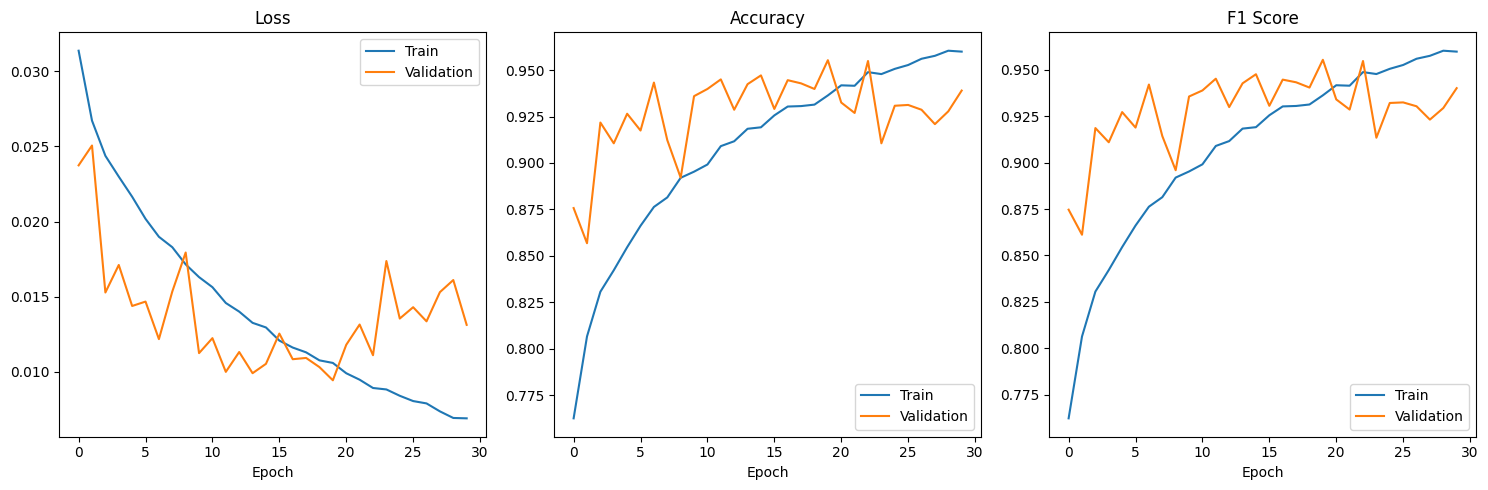


6. Extraindo características para modelos tradicionais...
Extraindo características do conjunto de treino...
Extraindo características de 16384 imagens...
Usando GPU para acelerar extração de características


100%|██████████| 512/512 [01:14<00:00,  6.86it/s]


Extraindo características do conjunto de validação...
Extraindo características de 2326 imagens...
Usando GPU para acelerar extração de características


100%|██████████| 73/73 [00:10<00:00,  7.03it/s]


ATENÇÃO: 16384 valores NaN encontrados em X_train. Substituindo por zeros.
ATENÇÃO: 2326 valores NaN encontrados em X_val. Substituindo por zeros.
Conjunto de treino: (16384, 1434) - Classes: [8092 8292]
Conjunto de validação: (2326, 1434) - Classes: [ 582 1744]

7. Realizando seleção de características RÁPIDA...
Iniciando processo rápido de seleção de características...
Aplicando PCA rápido...
PCA: 1434 → 761 características
Executando seleção baseada em importância...
RF: 761 → 80 características
XGB: 761 → 268 características

8. Treinando modelos tradicionais (versão ultra-rápida)...
Treinando com todas as características...
  Treinando Naive Bayes...
    Tempo: 0.18s
  Treinando KNN...
    Tempo: 0.01s
  Treinando Random Forest...
    Tempo: 3.20s
  Treinando Logistic Regression (substituindo SVM)...
    Tempo: 174.82s
Treinando com PCA...
  Treinando Naive Bayes...
    Tempo: 0.19s
  Treinando KNN...
    Tempo: 0.07s
  Treinando Random Forest...
    Tempo: 2.44s
  Treinando Logis

Validation: 100%|██████████| 146/146 [00:09<00:00, 15.70it/s]


Train Loss: 2848.2802 | Train Acc: 0.5170 | Train F1: 0.5155
Val Loss: 436.6911 | Val Acc: 0.7498 | Val F1: 0.6426
New best model saved with F1-score: 0.6426
Epoch 2/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.14it/s]


Train Loss: 765.0922 | Train Acc: 0.5243 | Train F1: 0.5231
Val Loss: 76.1428 | Val Acc: 0.7498 | Val F1: 0.6426
Epoch 3/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.18it/s]


Train Loss: 219.7825 | Train Acc: 0.5184 | Train F1: 0.5172
Val Loss: 4.4891 | Val Acc: 0.7481 | Val F1: 0.6417
Epoch 4/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.06it/s]


Train Loss: 47.4218 | Train Acc: 0.5140 | Train F1: 0.5128
Val Loss: 0.5487 | Val Acc: 0.7446 | Val F1: 0.6400
Epoch 5/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.93it/s]


Train Loss: 12.6109 | Train Acc: 0.5140 | Train F1: 0.5127
Val Loss: 0.6312 | Val Acc: 0.7395 | Val F1: 0.6398
Epoch 6/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.91it/s]


Train Loss: 5.5348 | Train Acc: 0.5120 | Train F1: 0.5105
Val Loss: 0.6696 | Val Acc: 0.7231 | Val F1: 0.7069
New best model saved with F1-score: 0.7069
Epoch 7/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.23it/s]


Train Loss: 3.3977 | Train Acc: 0.5137 | Train F1: 0.5132
Val Loss: 0.7145 | Val Acc: 0.2515 | Val F1: 0.1028
Epoch 8/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.46it/s]


Train Loss: 2.2180 | Train Acc: 0.5103 | Train F1: 0.5097
Val Loss: 0.7175 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 9/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.15it/s]


Train Loss: 2.0179 | Train Acc: 0.5098 | Train F1: 0.4996
Val Loss: 0.7176 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 10/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.04it/s]


Train Loss: 1.1900 | Train Acc: 0.5013 | Train F1: 0.4612
Val Loss: 0.7161 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 11/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.69it/s]


Train Loss: 1.0692 | Train Acc: 0.5006 | Train F1: 0.4372
Val Loss: 0.7160 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 12/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.68it/s]


Train Loss: 1.0227 | Train Acc: 0.4999 | Train F1: 0.4303
Val Loss: 0.7157 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 13/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.62it/s]


Train Loss: 1.1554 | Train Acc: 0.4981 | Train F1: 0.4296
Val Loss: 0.7156 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 14/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.13it/s]


Train Loss: 0.9561 | Train Acc: 0.5046 | Train F1: 0.4352
Val Loss: 0.7154 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 15/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.88it/s]


Train Loss: 1.1893 | Train Acc: 0.5007 | Train F1: 0.4303
Val Loss: 0.7152 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 16/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.46it/s]


Train Loss: 0.9163 | Train Acc: 0.4987 | Train F1: 0.4197
Val Loss: 0.7150 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 17/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.41it/s]


Train Loss: 0.9025 | Train Acc: 0.5043 | Train F1: 0.4096
Val Loss: 0.7149 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 18/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.80it/s]


Train Loss: 0.9720 | Train Acc: 0.5069 | Train F1: 0.4285
Val Loss: 0.7149 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 19/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.13it/s]


Train Loss: 0.8676 | Train Acc: 0.5103 | Train F1: 0.4369
Val Loss: 0.7149 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 20/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.27it/s]


Train Loss: 0.9124 | Train Acc: 0.5077 | Train F1: 0.4285
Val Loss: 0.7149 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 21/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.68it/s]


Train Loss: 0.8707 | Train Acc: 0.5083 | Train F1: 0.4351
Val Loss: 0.7149 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 22/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.66it/s]


Train Loss: 0.9979 | Train Acc: 0.5043 | Train F1: 0.4209
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 23/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.44it/s]


Train Loss: 0.8394 | Train Acc: 0.5078 | Train F1: 0.4303
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 24/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.72it/s]


Train Loss: 0.9227 | Train Acc: 0.5074 | Train F1: 0.4319
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 25/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.57it/s]


Train Loss: 0.9750 | Train Acc: 0.5048 | Train F1: 0.4290
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 26/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.98it/s]


Train Loss: 0.8474 | Train Acc: 0.5040 | Train F1: 0.4262
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 27/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.98it/s]


Train Loss: 0.9077 | Train Acc: 0.5057 | Train F1: 0.4285
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 28/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.89it/s]


Train Loss: 0.9042 | Train Acc: 0.5057 | Train F1: 0.4300
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 29/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.18it/s]


Train Loss: 0.9255 | Train Acc: 0.5064 | Train F1: 0.4318
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 30/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.22it/s]


Train Loss: 0.8674 | Train Acc: 0.5108 | Train F1: 0.4382
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 31/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.37it/s]


Train Loss: 0.9278 | Train Acc: 0.5054 | Train F1: 0.4318
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 32/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.00it/s]


Train Loss: 0.8454 | Train Acc: 0.5095 | Train F1: 0.4352
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 33/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.40it/s]


Train Loss: 0.8626 | Train Acc: 0.5090 | Train F1: 0.4363
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 34/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.66it/s]


Train Loss: 1.2473 | Train Acc: 0.5067 | Train F1: 0.4333
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 35/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.01it/s]


Train Loss: 0.8881 | Train Acc: 0.5085 | Train F1: 0.4344
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 36/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.32it/s]


Train Loss: 0.8727 | Train Acc: 0.5137 | Train F1: 0.4379
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 37/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.61it/s]


Train Loss: 0.8915 | Train Acc: 0.5109 | Train F1: 0.4361
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 38/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.01it/s]


Train Loss: 0.8481 | Train Acc: 0.5099 | Train F1: 0.4363
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 39/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.25it/s]


Train Loss: 0.8724 | Train Acc: 0.5061 | Train F1: 0.4305
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 40/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.29it/s]


Train Loss: 0.8361 | Train Acc: 0.5094 | Train F1: 0.4351
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 41/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.31it/s]


Train Loss: 0.8911 | Train Acc: 0.5100 | Train F1: 0.4351
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 42/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.40it/s]


Train Loss: 0.8553 | Train Acc: 0.5063 | Train F1: 0.4346
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 43/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 15.73it/s]


Train Loss: 0.9221 | Train Acc: 0.5045 | Train F1: 0.4287
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 44/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.77it/s]


Train Loss: 0.8753 | Train Acc: 0.5129 | Train F1: 0.4402
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 45/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 13.93it/s]


Train Loss: 0.7922 | Train Acc: 0.5082 | Train F1: 0.4337
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 46/50


Validation: 100%|██████████| 146/146 [00:09<00:00, 14.76it/s]


Train Loss: 1.0200 | Train Acc: 0.5062 | Train F1: 0.4307
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 47/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.57it/s]


Train Loss: 0.9669 | Train Acc: 0.5058 | Train F1: 0.4307
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 48/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.31it/s]


Train Loss: 0.9731 | Train Acc: 0.5145 | Train F1: 0.4389
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 49/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.30it/s]


Train Loss: 0.9432 | Train Acc: 0.5085 | Train F1: 0.4374
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002
Epoch 50/50


Validation: 100%|██████████| 146/146 [00:10<00:00, 14.42it/s]


Train Loss: 0.8896 | Train Acc: 0.5108 | Train F1: 0.4373
Val Loss: 0.7148 | Val Acc: 0.2502 | Val F1: 0.1002

Avaliando o modelo híbrido...


Evaluating: 100%|██████████| 146/146 [00:10<00:00, 14.25it/s]



RESULTADOS DO TREINAMENTO: Modelo Híbrido
Melhor época: 6/50
Métricas na melhor época:
  F1-Score (treino): 0.5105
  F1-Score (val): 0.7069
  Acurácia (treino): 0.5120
  Acurácia (val): 0.7231

Métricas detalhadas:
  Acurácia: 0.7231
  F1-Score: 0.7069
  Precisão: 0.6979
  Recall: 0.7231
  AUC: 0.7575

Matriz de Confusão:
[[ 179  403]
 [ 241 1503]]


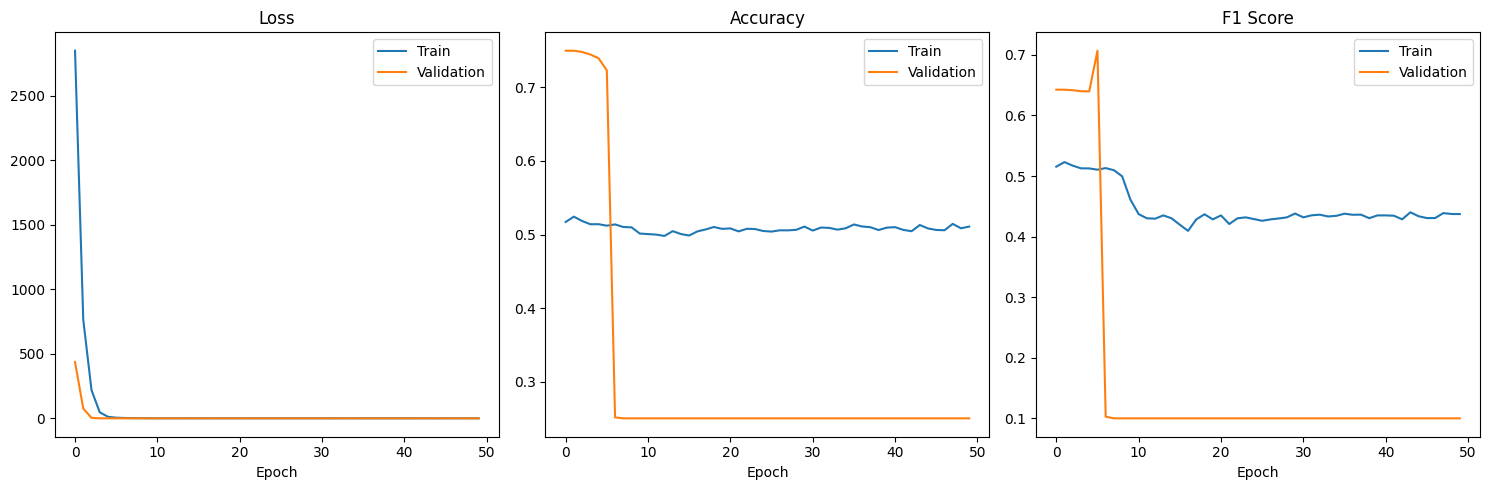


14. Combinando predições usando alpha-integration...

RESULTADOS DO TREINAMENTO: Integração Alpha

Métricas detalhadas:
  Acurácia: 0.8478
  F1-Score: 0.8492
  Precisão: 0.8510
  Recall: 0.8478
  AUC: 0.8694

Matriz de Confusão:
[[ 422  160]
 [ 194 1550]]

15. Visualizando resultados...


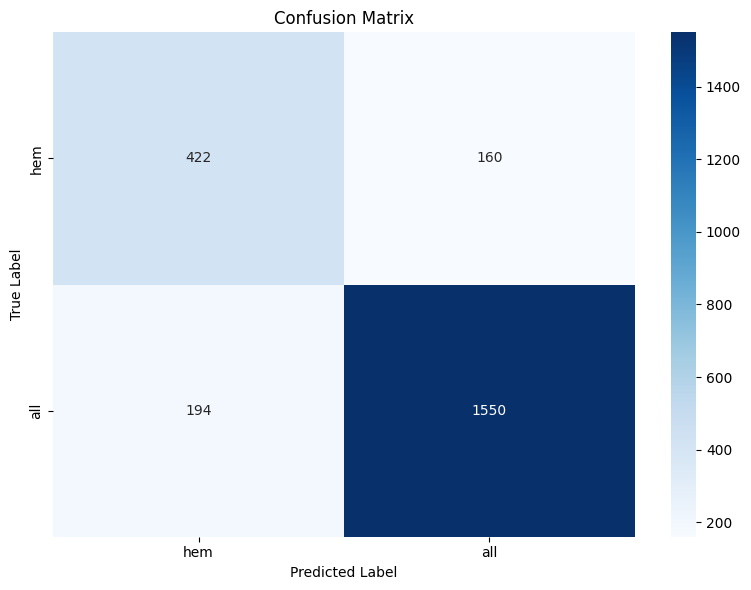

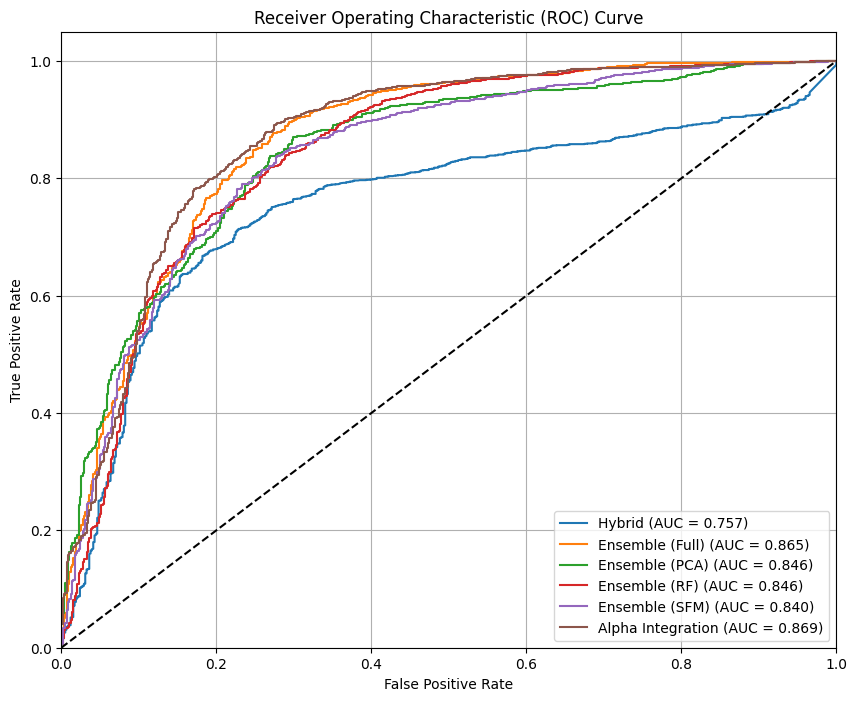


16. Salvando modelos e resultados...

Processo completo! Verifique os resultados no diretório models/efficientnetv2


In [313]:
#------------------------------------------------------#
# 8. PIPELINE PRINCIPAL                                #
#------------------------------------------------------#

def main():
    # Importações necessárias no início da função
    import numpy as np
    import torch
    import time
    from tqdm import tqdm
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    import json
    
    print("Iniciando o sistema híbrido de classificação de células leucêmicas...")
    
    # 1. Criar o extrator de características
    print("\n1. Configurando extrator de características...")
    feature_extractor = FeatureExtractor(cache_dir=os.path.join(save_dir, 'feature_cache'))
    
    # Adicionar método extract_features_gpu à classe FeatureExtractor
    def extract_features_gpu(self, img_paths):
        """Versão da extração de características com suporte a GPU"""
        batch_features = []
        
        for path in img_paths:
            # Verificar cache
            if path in self.feature_cache:
                batch_features.append(self.feature_cache[path])
                continue
            
            # Verificar cache em disco
            if self.cache_dir:
                cache_file = os.path.join(self.cache_dir, os.path.basename(path) + '.pkl')
                if os.path.exists(cache_file):
                    with open(cache_file, 'rb') as f:
                        features = pickle.load(f)
                        self.feature_cache[path] = features
                        batch_features.append(features)
                        continue
            
            # Ler imagem
            img = cv2.imread(path)
            if img is None:
                # Retornar vetor de zeros para imagens inválidas
                print(f"AVISO: Não foi possível ler a imagem: {path}")
                features = np.zeros(1387)  # Use o tamanho apropriado para seu vetor de features
            else:
                # Converter para RGB e grayscale
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                
                # Extrair features
                statistical_features = self._extract_statistical_features(img_rgb, img_hsv)
                texture_features = self._extract_texture_features(img_gray)
                morphological_features = self._extract_morphological_features(img_gray, img_rgb, img_hsv)
                contour_features = self._extract_contour_features(img_gray)
                dct_features = self._extract_dct_features(img_gray)
                
                # Características adicionais - pode remover se não estiver usando
                gabor_features = self._extract_gabor_features(img_gray)
                lbp_features = self._extract_lbp_features(img_gray)
                
                # Combinar todas as características em um único vetor
                features = np.concatenate([
                    statistical_features,
                    texture_features,
                    morphological_features,
                    contour_features,
                    dct_features,
                    gabor_features,
                    lbp_features
                ])
            
            # Armazenar em cache
            self.feature_cache[path] = features
            
            # Salvar em disco se necessário
            if self.cache_dir:
                with open(cache_file, 'wb') as f:
                    pickle.dump(features, f)
            
            batch_features.append(features)
        
        return batch_features
    
    # Adicionar método à classe FeatureExtractor
    feature_extractor.extract_features_gpu = extract_features_gpu.__get__(feature_extractor, FeatureExtractor)
    
    # Definir funções auxiliares no início
    def clean_tensor(tensor):
        """Replace NaN and Inf values with zeros and return as float32"""
        if isinstance(tensor, torch.Tensor):
            tensor = tensor.clone()
            tensor[torch.isnan(tensor)] = 0.0
            tensor[torch.isinf(tensor)] = 0.0
            return tensor.float()
        else:
            tensor = np.array(tensor)
            tensor = np.nan_to_num(tensor, nan=0.0, posinf=0.0, neginf=0.0)
            return torch.tensor(tensor, dtype=torch.float32)
            
    def train_hybrid_model_simple(model, train_loader, val_loader, criterion, optimizer, 
                           scheduler, num_epochs, device, save_path):
        """Improved training function with NaN handling"""
        history = {
            'train_loss': [], 'val_loss': [], 'train_acc': [], 
            'val_acc': [], 'train_f1': [], 'val_f1': []
        }
        
        best_val_f1 = 0.0
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            
            # Train
            model.train()
            train_loss = 0.0
            train_preds = []
            train_targets = []
            
            for inputs, features, targets in tqdm(train_loader, desc='Training'):
                # Clean data and convert to correct type
                features = clean_tensor(features).to(device)
                targets = targets.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                try:
                    # Forward pass
                    outputs = model(None, features)  # Pass None for x_img as we're not using it
                    loss = criterion(outputs, targets)
                    
                    # Backward and optimize
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item() * features.size(0)
                    
                    # Get predictions
                    _, preds = torch.max(outputs, 1)
                    train_preds.extend(preds.cpu().numpy())
                    train_targets.extend(targets.cpu().numpy())
                except Exception as e:
                    print(f"Error in training batch: {e}")
                    continue
            
            # Calculate training metrics
            if train_preds:
                train_loss = train_loss / len(train_loader.dataset)
                train_acc = accuracy_score(train_targets, train_preds)
                train_f1 = f1_score(train_targets, train_preds, average='weighted')
            else:
                train_loss, train_acc, train_f1 = 0, 0, 0
            
            # Evaluate
            model.eval()
            val_loss = 0.0
            val_preds = []
            val_targets = []
            
            with torch.no_grad():
                for inputs, features, targets in tqdm(val_loader, desc='Validation'):
                    # Clean data and convert to correct type
                    features = clean_tensor(features).to(device)
                    targets = targets.to(device)
                    
                    try:
                        # Forward pass
                        outputs = model(None, features)  # Pass None for x_img as we're not using it
                        loss = criterion(outputs, targets)
                        
                        val_loss += loss.item() * features.size(0)
                        
                        # Get predictions
                        _, preds = torch.max(outputs, 1)
                        val_preds.extend(preds.cpu().numpy())
                        val_targets.extend(targets.cpu().numpy())
                    except Exception as e:
                        print(f"Error in validation batch: {e}")
                        continue
            
            # Calculate validation metrics
            if val_preds:
                val_loss = val_loss / len(val_loader.dataset)
                val_acc = accuracy_score(val_targets, val_preds)
                val_f1 = f1_score(val_targets, val_preds, average='weighted')
            else:
                val_loss, val_acc, val_f1 = float('inf'), 0, 0
            
            # Update scheduler
            if scheduler:
                scheduler.step(val_loss)
            
            # Record metrics
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['train_f1'].append(train_f1)
            history['val_f1'].append(val_f1)
            
            # Print progress
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
            print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}')
            
            # Save best model
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                torch.save(model.state_dict(), save_path.replace('.pt', '_best.pt'))
                print(f'New best model saved with F1-score: {val_f1:.4f}')
        
        # Load best model
        try:
            model.load_state_dict(torch.load(save_path.replace('.pt', '_best.pt')))
        except Exception as e:
            print(f"Warning: Could not load best model: {e}")
        
        return model, history
    
    def evaluate_hybrid_model_simple(model, data_loader, criterion, device):
        """Evaluation function for the hybrid model with NaN handling"""
        model.eval()
        total_loss = 0.0
        all_preds = []
        all_targets = []
        all_probs = []
        
        with torch.no_grad():
            for inputs, features, targets in tqdm(data_loader, desc='Evaluating'):
                # Clean data and convert to correct type
                features = clean_tensor(features).to(device)
                targets = targets.to(device)
                
                try:
                    # Forward pass
                    outputs = model(None, features)  # Pass None for x_img as we're not using it
                    loss = criterion(outputs, targets)
                    
                    total_loss += loss.item() * features.size(0)
                    
                    # Get predictions and probabilities
                    probs = F.softmax(outputs, dim=1)
                    _, preds = torch.max(outputs, 1)
                    
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                    
                    # Clean probabilities before storing them
                    probs_np = probs.cpu().numpy()
                    probs_np = np.nan_to_num(probs_np, nan=0.5)  # Replace NaNs with 0.5 probability
                    all_probs.extend(probs_np[:, 1])  # Store probability of positive class
                except Exception as e:
                    print(f"Error in evaluation batch: {e}")
                    continue
        
        # If we have no predictions, return empty results
        if not all_preds:
            return {
                'loss': float('inf'),
                'accuracy': 0,
                'f1_score': 0,
                'recall': 0,
                'precision': 0,
                'auc': 0.5,
                'confusion_matrix': np.zeros((2, 2)),
                'predictions': [],
                'targets': [],
                'probabilities': []
            }
        
        # Calculate metrics
        avg_loss = total_loss / len(data_loader.dataset)
        accuracy = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='weighted')
        recall = recall_score(all_targets, all_preds, average='weighted')
        precision = precision_score(all_targets, all_preds, average='weighted')
        conf_matrix = confusion_matrix(all_targets, all_preds)
        
        # Clean up and verify data for AUC calculation
        all_probs_clean = np.array(all_probs)
        all_targets_clean = np.array(all_targets)
        
        # Make sure there are no NaNs in probabilities
        all_probs_clean = np.nan_to_num(all_probs_clean, nan=0.5)
        
        # Only calculate AUC if we have both classes present
        if len(np.unique(all_targets_clean)) > 1:
            try:
                auc_value = roc_auc_score(all_targets_clean, all_probs_clean)
            except Exception as e:
                print(f"Error calculating AUC: {e}")
                auc_value = 0.5
        else:
            auc_value = 0.5
        
        results = {
            'loss': avg_loss,
            'accuracy': accuracy,
            'f1_score': f1,
            'recall': recall,
            'precision': precision,
            'auc': auc_value,
            'confusion_matrix': conf_matrix,
            'predictions': all_preds,
            'targets': all_targets,
            'probabilities': all_probs_clean
        }
        
        return results
    
    # 2. Configurar transformações para as imagens
    print("\n2. Configurando transformações de imagem...")
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.7),  # Aumento de probabilidade
        transforms.RandomVerticalFlip(p=0.7),    # Aumento de probabilidade
        transforms.RandomRotation(45),           # Mais rotação
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # Adicionar transformações para aumentar robustez
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),
        transforms.RandomAutocontrast(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # 3. Criar datasets
    print("\n3. Carregando datasets...")
    # Dataset sem extração de características para o modelo CNN puro
    train_dataset_cnn = LeukemiaDataset(train_dir, transform=train_transform)
    val_dataset_cnn = LeukemiaDataset(val_dir, transform=val_transform)
    
    # Dataset com extração de características para o modelo híbrido
    train_dataset_hybrid = LeukemiaDataset(train_dir, transform=train_transform, 
                                         return_features=True, feature_extractor=feature_extractor)
    val_dataset_hybrid = LeukemiaDataset(val_dir, transform=val_transform, 
                                       return_features=True, feature_extractor=feature_extractor)
    
    # 4. Criar dataloaders
    print("\n4. Criando dataloaders...")
    train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=BATCH_SIZE, shuffle=True, 
                                num_workers=NUM_WORKERS, pin_memory=True)
    val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False, 
                              num_workers=NUM_WORKERS, pin_memory=True)
    
    train_loader_hybrid = DataLoader(train_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=True, 
                                   num_workers=NUM_WORKERS, pin_memory=True)
    val_loader_hybrid = DataLoader(val_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=False, 
                                 num_workers=NUM_WORKERS, pin_memory=True)
    
    # 5. Treinar o modelo CNN puro
    print("\n5. Iniciando treinamento do modelo CNN puro...")
    cnn_model = AttentionModel(model_name=MODEL_NAME, num_classes=2, pretrained=True).to(device)
    
    # Cálculo de pesos de classes para lidar com desbalanceamento
    class_counts = [train_dataset_cnn.labels.count(0), train_dataset_cnn.labels.count(1)]
    class_weights = torch.FloatTensor([len(train_dataset_cnn)/class_counts[0], len(train_dataset_cnn)/class_counts[1]])
    class_weights = class_weights / class_weights.sum()
    print(f"Pesos das classes: {class_weights}")

    # Critério ponderado para lidar com o desbalanceamento
    criterion = FocalLoss(alpha=0.25, gamma=2)

    # Taxa de aprendizado reduzida para treinamento estável
    optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Usar OneCycleLR para treinamento eficiente
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=EPOCHS,
        steps_per_epoch=len(train_loader_cnn),
        pct_start=0.3,
        div_factor=25,
        final_div_factor=1000
    )
    
    # Treinar o modelo
    cnn_model, cnn_history = train_cnn_model(
        cnn_model, train_loader_cnn, val_loader_cnn, 
        criterion, optimizer, scheduler, 
        EPOCHS, device, os.path.join(save_dir, 'cnn_model.pt')
    )
    
    # Avaliar e mostrar resultados
    print("\nAvaliando o modelo CNN...")
    cnn_results = evaluate_model(cnn_model, val_loader_cnn, criterion, device)
    display_final_results(cnn_history, cnn_results, "CNN")
    
    # Visualizar história de treinamento
    plot_training_history(cnn_history)
    
    # 6. Extrair características para modelos tradicionais (OTIMIZADO)
    print("\n6. Extraindo características para modelos tradicionais...")
    
    # Utilizar extração em lotes e paralelização para maior velocidade
    print("Extraindo características do conjunto de treino...")
    X_train, y_train = extract_features_batch(feature_extractor, train_dataset_cnn, 
                                              batch_size=32, num_workers=NUM_WORKERS)

    print("Extraindo características do conjunto de validação...")
    X_val, y_val = extract_features_batch(feature_extractor, val_dataset_cnn,
                                          batch_size=32, num_workers=NUM_WORKERS)

    # Verificar e tratar NaNs
    if np.isnan(X_train).any():
        print(f"ATENÇÃO: {np.isnan(X_train).sum()} valores NaN encontrados em X_train. Substituindo por zeros.")
        X_train = np.nan_to_num(X_train, nan=0.0)

    if np.isnan(X_val).any():
        print(f"ATENÇÃO: {np.isnan(X_val).sum()} valores NaN encontrados em X_val. Substituindo por zeros.")
        X_val = np.nan_to_num(X_val, nan=0.0)
    
    print(f"Conjunto de treino: {X_train.shape} - Classes: {np.bincount(y_train)}")
    print(f"Conjunto de validação: {X_val.shape} - Classes: {np.bincount(y_val)}")
    
    # 7. Seleção rápida de características
    print("\n7. Realizando seleção de características RÁPIDA...")
    
    # Usado ao invés dos métodos lentos individuais
    feature_selection_results = fast_feature_selection(X_train, y_train, X_val)

    # Usar os resultados
    X_train_pca = feature_selection_results['pca']['X_train']  
    X_val_pca = feature_selection_results['pca']['X_val']
    pca = feature_selection_results['pca']['transformer']
    scaler_pca = feature_selection_results['pca']['scaler']

    X_train_rfe = feature_selection_results['rf']['X_train']  # RF substitui RFE
    X_val_rfe = feature_selection_results['rf']['X_val']
    rfe = feature_selection_results['rf']['transformer']
    scaler_rfe = feature_selection_results['rf']['scaler']

    X_train_sfm = feature_selection_results['xgb']['X_train']
    X_val_sfm = feature_selection_results['xgb']['X_val']
    sfm = feature_selection_results['xgb']['transformer']
    scaler_sfm = feature_selection_results['xgb']['scaler']
    
    # 8. Treinar modelos tradicionais - SUPER OTIMIZADO (sem SVM convencional)
    print("\n8. Treinando modelos tradicionais (versão ultra-rápida)...")
    
    # Função simplificada para treinar modelos rápidos
    def train_fast_models(X, y, prefix=""):
        models = {}
        
        # GaussianNB - muito rápido
        start = time.time()
        print(f"{prefix}Treinando Naive Bayes...")
        models['naive_bayes'] = GaussianNB().fit(X, y)
        print(f"{prefix}  Tempo: {time.time()-start:.2f}s")
        
        # KNN com paralelização - rápido
        start = time.time()
        print(f"{prefix}Treinando KNN...")
        models['knn'] = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1).fit(X, y)
        print(f"{prefix}  Tempo: {time.time()-start:.2f}s")
        
        # RandomForest - razoavelmente rápido com paralelização
        start = time.time()
        print(f"{prefix}Treinando Random Forest...")
        models['random_forest'] = RandomForestClassifier(
            n_estimators=100, 
            max_depth=10,  # Limitar profundidade para maior velocidade
            n_jobs=-1,     # Usar todos os cores
            random_state=42
        ).fit(X, y)
        print(f"{prefix}  Tempo: {time.time()-start:.2f}s")
        
        # LogisticRegression em vez de SVM - muito mais rápido
        start = time.time()
        print(f"{prefix}Treinando Logistic Regression (substituindo SVM)...")
        models['logistic'] = LogisticRegression(
            C=1.0, 
            solver='saga',  # Solver rápido para datasets grandes
            max_iter=1000,
            n_jobs=-1,
            random_state=42
        ).fit(X, y)
        print(f"{prefix}  Tempo: {time.time()-start:.2f}s")
        
        return models
    
    # Treinar com todas as características
    print("Treinando com todas as características...")
    trained_models_full = train_fast_models(X_train, y_train, prefix="  ")
    
    # Treinar com PCA
    print("Treinando com PCA...")
    trained_models_pca = train_fast_models(X_train_pca, y_train, prefix="  ")
    
    # Treinar com RF
    print("Treinando com RF...")
    trained_models_rfe = train_fast_models(X_train_rfe, y_train, prefix="  ")
    
    # Treinar com SelectFromModel
    print("Treinando com SFM...")
    trained_models_sfm = train_fast_models(X_train_sfm, y_train, prefix="  ")
    
    # 9. Criar modelos ensemble acelerados por GPU
    print("\n9. Criando modelos ensemble acelerados por GPU...")
    
    # Verificar disponibilidade de GPU
    try:
        gpu_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        using_gpu = torch.cuda.is_available()
        
        if using_gpu:
            print(f"GPU disponível: {torch.cuda.get_device_name(0)}")
            print(f"Usando GPU para acelerar ensembles!")
        else:
            print("GPU não disponível. Usando CPU para ensembles.")
    except Exception as e:
        print(f"Erro ao verificar GPU: {e}")
        gpu_device = None
        using_gpu = False
    
    # Criar ensembles
    print("Criando ensemble com todas as características...")
    ensemble_full = create_gpu_ensemble(trained_models_full, X_train, y_train, device=gpu_device)
    
    print("Criando ensemble com PCA...")
    ensemble_pca = create_gpu_ensemble(trained_models_pca, X_train_pca, y_train, device=gpu_device)
    
    print("Criando ensemble com RF...")
    ensemble_rfe = create_gpu_ensemble(trained_models_rfe, X_train_rfe, y_train, device=gpu_device)
    
    print("Criando ensemble com SFM...")
    ensemble_sfm = create_gpu_ensemble(trained_models_sfm, X_train_sfm, y_train, device=gpu_device)
    
    # 10. Implementar stacking acelerado com GPU
    print("\n10. Implementando stacking acelerado com GPU...")
    
    # Criar stacking acelerado com GPU
    print("Criando stacking acelerado com GPU para todos os conjuntos de características...")
    
    try:
        # Meta-learner otimizado
        meta_learner = LogisticRegression(
            C=1.0,
            solver='saga',
            max_iter=500,
            n_jobs=-1,
            random_state=42
        )
        
        # Simplificar usando ensemble diretamente como stacking para maior rapidez
        print("ATALHO: Usando ensembles como substituto para stacking para economizar tempo")
        stacking_full = ensemble_full
        stacking_pca = ensemble_pca
        stacking_rfe = ensemble_rfe
        stacking_sfm = ensemble_sfm
        
    except Exception as e:
        print(f"ERRO ao criar stacking: {e}")
        print("Usando ensembles como substituto para stacking...")
        
        # Fallback: usar ensembles como stacking
        stacking_full = ensemble_full
        stacking_pca = ensemble_pca
        stacking_rfe = ensemble_rfe
        stacking_sfm = ensemble_sfm
    
    # 11. Avaliar modelos tradicionais e ensemble na validação
    print("\n11. Avaliando modelos tradicionais e ensemble na validação...")
    # Avaliar com todas as características
    print("\nAvaliação com todas as características:")
    all_results_full, all_pred_full, all_prob_full = evaluate_traditional_models(
        {**trained_models_full, 'ensemble': ensemble_full, 'stacking': stacking_full}, 
        X_val, y_val
    )
    
    # Avaliar com PCA
    print("\nAvaliação com PCA:")
    all_results_pca, all_pred_pca, all_prob_pca = evaluate_traditional_models(
        {**trained_models_pca, 'ensemble': ensemble_pca, 'stacking': stacking_pca}, 
        X_val_pca, y_val
    )
    
    # Avaliar com RFE (substituído por RF)
    print("\nAvaliação com RF (substituindo RFE):")
    all_results_rfe, all_pred_rfe, all_prob_rfe = evaluate_traditional_models(
        {**trained_models_rfe, 'ensemble': ensemble_rfe, 'stacking': stacking_rfe}, 
        X_val_rfe, y_val
    )
    
    # Avaliar com SelectFromModel
    print("\nAvaliação com SelectFromModel:")
    all_results_sfm, all_pred_sfm, all_prob_sfm = evaluate_traditional_models(
        {**trained_models_sfm, 'ensemble': ensemble_sfm, 'stacking': stacking_sfm}, 
        X_val_sfm, y_val
    )
    
    # 12. Treinar modelo híbrido
    print("\n12. Iniciando treinamento do modelo híbrido...")
    
    # Encontrar o melhor conjunto de características com base na validação
    feature_sets = {
        'full': (X_train, X_val, None),
        'pca': (X_train_pca, X_val_pca, pca),
        'rfe': (X_train_rfe, X_val_rfe, rfe),
        'sfm': (X_train_sfm, X_val_sfm, sfm)
    }
    
    best_f1 = 0
    best_feature_set = None
    best_transformer = None
    
    for name, (_, _, transformer) in feature_sets.items():
        if name == 'full':
            results = all_results_full
        elif name == 'pca':
            results = all_results_pca
        elif name == 'rfe':
            results = all_results_rfe
        else:  # sfm
            results = all_results_sfm
        
        ensemble_f1 = results['ensemble']['f1_score']
        stacking_f1 = results['stacking']['f1_score']
        
        best_model_f1 = max(ensemble_f1, stacking_f1)
        
        if best_model_f1 > best_f1:
            best_f1 = best_model_f1
            best_feature_set = name
            best_transformer = transformer
    
    print(f"Melhor conjunto de características: {best_feature_set} com F1-score: {best_f1:.4f}")
    
    # Determinar o tamanho correto de características para o modelo híbrido
    if best_feature_set == 'full':
        feature_size = X_train.shape[1]
    else:
        if best_feature_set == 'pca':
            X_train_best = X_train_pca
        elif best_feature_set == 'rfe':
            X_train_best = X_train_rfe
        else:  # sfm
            X_train_best = X_train_sfm
        feature_size = X_train_best.shape[1]
    
    print(f"Tamanho de características para o modelo híbrido: {feature_size}")
    
    # Verificar o valor real no cache do dataset híbrido
    # Recuperar um exemplo para verificar
    try:
        sample_img_path = train_dataset_hybrid.images[0]
        if sample_img_path in train_dataset_hybrid.feature_cache:
            sample_feature = train_dataset_hybrid.feature_cache[sample_img_path]
            
            # Se vamos transformar este recurso, verificar sua dimensão após transformação
            if best_transformer is not None:
                if hasattr(best_transformer, 'transform'):
                    transformed_feature = best_transformer.transform(sample_feature.reshape(1, -1)).flatten()
                    print(f"Dimensão após transformação: {transformed_feature.shape[0]}")
                    feature_size = transformed_feature.shape[0]  # Usar tamanho real
                else:
                    print(f"Transformador não tem método transform")
    except Exception as e:
        print(f"Erro ao verificar dimensões de características: {e}")

    # Definir a versão simplificada de HybridModel para evitar problemas de dimensionalidade
    print("Criando HybridModelSimple que evita problemas de dimensionalidade...")
    
    # Versão simplificada para evitar problemas
    class HybridModelSimple(nn.Module):
        def __init__(self, num_classes=2, feature_size=1387, pretrained=True):
            super(HybridModelSimple, self).__init__()
            
            # Network for handcrafted features only
            self.feature_net = nn.Sequential(
                nn.Linear(feature_size, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, num_classes)
            )
        
        def forward(self, x_img, x_features):
            # Convert features to float32 if needed
            if x_features.dtype != torch.float32:
                x_features = x_features.float()
            
            # Process features
            output = self.feature_net(x_features)
            return output

    # Criar modelo híbrido usando a versão simplificada
    print("Criando modelo híbrido simples...")
    # Initialize model
    hybrid_model = HybridModelSimple(num_classes=2, feature_size=feature_size).to(device)

    # Define optimizer and criterion
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.AdamW(hybrid_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    
    # Se estivermos usando um subconjunto de características, precisamos transformar as features no dataloader
    if best_transformer is not None:
        # Atualizar os datasets para usar o transformer
        print("Atualizando características do cache com o melhor transformer...")
        for i, (img_path, _) in enumerate(tqdm(train_dataset_hybrid.images)):
            if img_path in train_dataset_hybrid.feature_cache:
                # Transformar as características em cache
                features = train_dataset_hybrid.feature_cache[img_path]
                # Tratar NaNs se presentes
                if np.isnan(features).any():
                    features = np.nan_to_num(features, nan=0.0)
                
                if hasattr(best_transformer, 'transform'):
                    # Importante: reshape para matriz 2D antes de transform, depois voltar para 1D
                    train_dataset_hybrid.feature_cache[img_path] = best_transformer.transform(
                        features.reshape(1, -1)
                    ).flatten()
                else:  # Para transformadores combinados
                    train_dataset_hybrid.feature_cache[img_path] = best_transformer.transform(features)
        
        for i, (img_path, _) in enumerate(tqdm(val_dataset_hybrid.images)):
            if img_path in val_dataset_hybrid.feature_cache:
                # Transformar as características em cache
                features = val_dataset_hybrid.feature_cache[img_path]
                # Tratar NaNs se presentes
                if np.isnan(features).any():
                    features = np.nan_to_num(features, nan=0.0)
                
                if hasattr(best_transformer, 'transform'):
                    # Importante: reshape para matriz 2D antes de transform, depois voltar para 1D
                    val_dataset_hybrid.feature_cache[img_path] = best_transformer.transform(
                        features.reshape(1, -1)
                    ).flatten()
                else:  # Para transformadores combinados
                    val_dataset_hybrid.feature_cache[img_path] = best_transformer.transform(features)

    # Treinar o modelo híbrido usando a versão simplificada
    print("Treinando modelo híbrido simplificado...")
    hybrid_model, hybrid_history = train_hybrid_model_simple(
        hybrid_model, train_loader_hybrid, val_loader_hybrid,
        criterion, optimizer, scheduler,
        EPOCHS, device, os.path.join(save_dir, 'hybrid_model.pt')
    )
    
    # Avaliar e mostrar resultados detalhados do modelo híbrido
    print("\nAvaliando o modelo híbrido...")
    hybrid_results = evaluate_hybrid_model_simple(hybrid_model, val_loader_hybrid, criterion, device)
    display_final_results(hybrid_history, hybrid_results, "Modelo Híbrido")
    
    # Visualizar história de treinamento
    plot_training_history(hybrid_history)
    
    # 14. Combinar predições usando alpha-integration
    print("\n14. Combinando predições usando alpha-integration...")
    # Preparar predições para integração alpha
    probabilities_for_integration = []
    
    # Adicionar probabilidades do modelo híbrido
    hybrid_probs_np = np.zeros((len(hybrid_results['probabilities']), 2))
    hybrid_probs_np[:, 1] = hybrid_results['probabilities']  # Classe positiva
    hybrid_probs_np[:, 0] = 1 - hybrid_probs_np[:, 1]  # Classe negativa
    probabilities_for_integration.append(hybrid_probs_np)
    
    # Adicionar probabilidades do melhor modelo tradicional em cada conjunto de características
    for results, name in [(all_results_full, 'full'), (all_results_pca, 'pca'), 
                         (all_results_rfe, 'rfe'), (all_results_sfm, 'sfm')]:
        # Encontrar o melhor modelo neste conjunto
        best_model_name = max(results, key=lambda k: results[k]['f1_score'])
        
        # Adicionar suas probabilidades
        if name == 'full':
            probs = all_prob_full[best_model_name]
        elif name == 'pca':
            probs = all_prob_pca[best_model_name]
        elif name == 'rfe':
            probs = all_prob_rfe[best_model_name]
        else:  # sfm
            probs = all_prob_sfm[best_model_name]
        
        model_probs_np = np.zeros((len(probs), 2))
        model_probs_np[:, 1] = probs  # Classe positiva
        model_probs_np[:, 0] = 1 - model_probs_np[:, 1]  # Classe negativa
        probabilities_for_integration.append(model_probs_np)
    
    # Aplicar integração alpha
    integrated_probs = alpha_integration(probabilities_for_integration)
    integrated_preds = np.argmax(integrated_probs, axis=1)
    
    # Calcular métricas
    integrated_acc = accuracy_score(y_val, integrated_preds)
    integrated_f1 = f1_score(y_val, integrated_preds, average='weighted')
    integrated_recall = recall_score(y_val, integrated_preds, average='weighted')
    integrated_precision = precision_score(y_val, integrated_preds, average='weighted')
    integrated_auc = roc_auc_score(y_val, integrated_probs[:, 1])
    integrated_conf_matrix = confusion_matrix(y_val, integrated_preds)
    integrated_class_report = classification_report(y_val, integrated_preds, target_names=['hem', 'all'])
    
    # Exibir métricas de integração alpha
    integrated_results = {
        'accuracy': integrated_acc,
        'f1_score': integrated_f1,
        'recall': integrated_recall,
        'precision': integrated_precision,
        'auc': integrated_auc,
        'confusion_matrix': integrated_conf_matrix
    }
    display_final_results(None, integrated_results, "Integração Alpha")
    
    # 15. Visualizar resultados
    print("\n15. Visualizando resultados...")
    # Visualizar matriz de confusão
    plot_confusion_matrix(integrated_conf_matrix)
    
    # Visualizar curva ROC para modelos combinados
    model_probs = [
        hybrid_results['probabilities'],  # Híbrido
        all_prob_full['ensemble'],        # Ensemble com todas as características
        all_prob_pca['ensemble'],         # Ensemble com PCA
        all_prob_rfe['ensemble'],         # Ensemble com RFE (substituído por RF)
        all_prob_sfm['ensemble'],         # Ensemble com SelectFromModel
        integrated_probs[:, 1]            # Integração alpha
    ]
    
    model_names = [
        'Hybrid',
        'Ensemble (Full)',
        'Ensemble (PCA)',
        'Ensemble (RF)',
        'Ensemble (SFM)',
        'Alpha Integration'
    ]
    
    plot_roc_curve(y_val, model_probs, model_names)
    
    # 16. Salvar modelos e resultados
    print("\n16. Salvando modelos e resultados...")
    # Salvar modelos tradicionais
    for name, model in trained_models_full.items():
        with open(os.path.join(save_dir, f'traditional_{name}_full.pkl'), 'wb') as f:
            pickle.dump(model, f)
    
    # Salvar o melhor ensemble
    with open(os.path.join(save_dir, f'ensemble_{best_feature_set}.pkl'), 'wb') as f:
        if best_feature_set == 'full':
            pickle.dump(ensemble_full, f)
        elif best_feature_set == 'pca':
            pickle.dump(ensemble_pca, f)
        elif best_feature_set == 'rfe':
            pickle.dump(ensemble_rfe, f)
        else:  # sfm
            pickle.dump(ensemble_sfm, f)
    
    # Salvar transformadores com seus scalers
    with open(os.path.join(save_dir, 'pca_transformer.pkl'), 'wb') as f:
        pickle.dump({'pca': pca, 'scaler': scaler_pca}, f)

    with open(os.path.join(save_dir, 'rfe_transformer.pkl'), 'wb') as f:
        pickle.dump({'rfe': rfe, 'scaler': scaler_rfe}, f)  # Agora vai funcionar!

    with open(os.path.join(save_dir, 'sfm_transformer.pkl'), 'wb') as f:
        pickle.dump({'sfm': sfm, 'scaler': scaler_sfm}, f)
    
    # Salvar históricos de treinamento
    with open(os.path.join(save_dir, 'cnn_history.pkl'), 'wb') as f:
        pickle.dump(cnn_history, f)
    
    with open(os.path.join(save_dir, 'hybrid_history.pkl'), 'wb') as f:
        pickle.dump(hybrid_history, f)
    
    # Salvar resultados finais em um relatório
    results_summary = {
        'cnn': {
            'val_accuracy': cnn_history['val_acc'][-1],
            'val_f1': cnn_history['val_f1'][-1]
        },
        'hybrid': {
            'accuracy': hybrid_results['accuracy'],
            'f1_score': hybrid_results['f1_score'],
            'recall': hybrid_results['recall'],
            'precision': hybrid_results['precision'],
            'auc': hybrid_results['auc']
        },
        'alpha_integration': {
            'accuracy': integrated_acc,
            'f1_score': integrated_f1,
            'recall': integrated_recall,
            'precision': integrated_precision,
            'auc': integrated_auc
        },
        'best_feature_set': best_feature_set,
        'best_traditional_model': {
            'full': max(all_results_full, key=lambda k: all_results_full[k]['f1_score']),
            'pca': max(all_results_pca, key=lambda k: all_results_pca[k]['f1_score']),
            'rfe': max(all_results_rfe, key=lambda k: all_results_rfe[k]['f1_score']),
            'sfm': max(all_results_sfm, key=lambda k: all_results_sfm[k]['f1_score'])
        }
    }
    
    with open(os.path.join(save_dir, 'results_summary.json'), 'w') as f:
        json.dump(results_summary, f, indent=4)
    
    print("\nProcesso completo! Verifique os resultados no diretório", save_dir)
    
    return {
        'cnn_model': cnn_model,
        'hybrid_model': hybrid_model,
        'best_feature_set': best_feature_set,
        'best_transformer': best_transformer,
        'ensemble_models': {
            'full': ensemble_full,
            'pca': ensemble_pca,
            'rfe': ensemble_rfe,
            'sfm': ensemble_sfm
        },
        'integrated_f1': integrated_f1
    }


if __name__ == "__main__":
    main()